# Implement a scoring model

## Context
- The financial company ***Prêt à dépenser*** offers consumer credit for people with little or no loan history.


- The company is interested in identifying customers who will not pay the loan back to minimize the company’s financial losses. Hence, they want to implement a "credit scoring" tool to calculate the probability that a customer will repay his credit, and then classify the request as granted or denied credit.

## Goal:
- Develop a scoring model to predict the risk of non-repayment of a client.


- Build an interactive dashboard to interpret the results so that customer relations managers could explain credit decisions as transparently as possible, but also allow their customers to have access to their personal information and explore it easily.

## Objectives:

- Build a scoring model that will automatically predict the probability of a customer's bankruptcy.


- Build an interactive dashboard for customer relationship managers to interpret the predictions made by the model, and to improve the customer knowledge of customer relationship managers.


- Put into production the prediction scoring model using an API, as well as the interactive dashboard that calls the API for predictions.

## 1.0 Import Libraries

In [1]:
# Dataframe manipulation
import pandas as pd #for data wrangling
from pandas import MultiIndex, Int16Dtype

# Linear algebra
import numpy as np #for Scientific computations

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Evaluation Metrics
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, recall_score, log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

# Model selection
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.calibration import calibration_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Classifiers
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

# Smote functions for imbalancing
from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

# Feature selection and interpretation
import shap

# Save the model
import pickle

# MLflow
import mlflow

# Data drift analyses - Evidently
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataDriftTab, CatTargetDriftTab, NumTargetDriftTab
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataDriftProfileSection, CatTargetDriftProfileSection
from evidently import ColumnMapping

import re
import os

import time
%matplotlib inline 


# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

analyzers are deprecated, use metrics instead
dashboards are deprecated, use metrics instead
model profiles are deprecated, use metrics instead


## 2.0 Load the Datasets

#### Dataset descriptions
***application_{train|test}.csv***
- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.

***bureau.csv***

- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

***bureau_balance.csv***

- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

***POS_CASH_balance.csv***

- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

***credit_card_balance.csv***
- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

***previous_application.csv***
- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

***installments_payments.csv***

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

***HomeCredit_columns_description.csv***
This file contains descriptions for the columns in the various data files.

In [2]:
Train_df = pd.read_csv("D:/OC/Project 7/application_train.csv")
Test_df = pd.read_csv("D:/OC/Project 7/application_test.csv")
Description_df = pd.read_csv("D:/OC/Project 7/HomeCredit_columns_description.csv", encoding_errors='ignore')

## 3.0 Summary of the Datasets

In [3]:
files = ['application_train', 'application_test']

dfs = [Train_df, Test_df] 
for file in range(len(files)):
    print('{}: \n'.format(files[file]))
    print(dfs[file].info())
    print('Shape :', dfs[file].shape)
    print('Duplicates :', dfs[file].duplicated().sum())
    print('\n\n***********************************\n\n')

application_train: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
Shape : (307511, 122)
Duplicates : 0


***********************************


application_test: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None
Shape : (48744, 121)
Duplicates : 0


***********************************




### Train/Test Datasets 

In [4]:
Train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
Test_df.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


#### Column descriptions

In [6]:
pd.set_option('display.max_rows', 220)
Description_df

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [7]:
# check dimension of the original datasets
print(Train_df.shape, Test_df.shape)

(307511, 122) (48744, 121)


## 4.0 Data Exploration

#### Check the percentage of missing data in each column

In [8]:
# Function to calculate missing values by column# Funct 
def Missing_value(data):
    ''' function that returns the number and percentages of missing values in a tabular form'''
    # Total missing values
    missing_value = data.isnull().sum()
        
    # Percentage of missing values
    per_missing_value = data.isnull().sum()/len(data)*100
        
    # create a dataframe of the missing values
    Missing_Value_df = pd.concat([missing_value, per_missing_value], axis=1)
        
    # Rename the columns
    Missing_Value_df = Missing_Value_df.rename(
    columns = {0 : 'Missing Values', 1 : '% of Missing Values'})
        
    # Sort the table by percentage of missing descending
    Missing_Value_df = round(Missing_Value_df[Missing_Value_df.iloc[:,1] > 0].sort_values('% of Missing Values', 
                                                                                               ascending=False), 1)     
    print("There are " + str(len(Missing_Value_df)) + " columns that have missing values.")
    return Missing_Value_df

In [9]:
# apply the function to train dataset
MV_Train = Missing_value(Train_df)
MV_Train

There are 67 columns that have missing values.


,Missing Values,% of Missing Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [10]:
# Test data
MV_Test = Missing_value(Test_df)
MV_Test

There are 64 columns that have missing values.


,Missing Values,% of Missing Values
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


#### Distribution and visualization of the target feature
 - label 0 = repaid (non-default) loan and 1 = unpaid (defaulted) loan

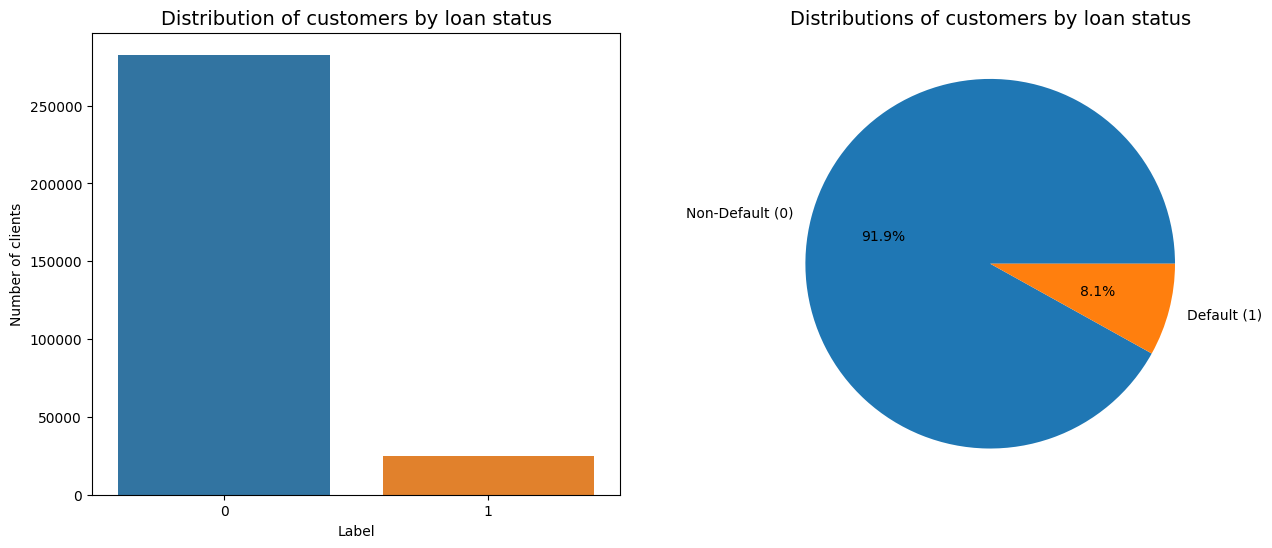

In [12]:
# check the distribution of loan status (Target) - reimbursed and non-reimbursed loans
labels = ['Non-Default (0)', 'Default (1)']

def count_plot(Data, variable):
    ''' function to plot distribution of variables and their percentages'''
    fig = plt.figure(figsize=(15,6))
    
    # create barplot of distribution according to number of clients
    ax1 = fig.add_subplot(121)
    ax1= sns.countplot(data=Data, x=variable)
    #ax1.bar_label(ax1.containers[0], label_type='edge', color='black')
    plt.ylabel('Number of clients')
    plt.xlabel('Label')
    plt.title('Distribution of customers by loan status', fontsize = 14)
    
    ax2 = fig.add_subplot(122)
    ax2 = plt.pie(Data[variable].value_counts(), labels = labels, autopct='%1.1f%%', radius=1)
    plt.title('Distributions of customers by loan status', fontsize = 14)
        
    plt.show()
    

    # visualize target distribution for train data
count_plot(Train_df, 'TARGET')

- The target variables are highly imbalanced with a 282686 (92%) to 24825 (8%) ratio of repaid (0) to defaulted (1) loans, respectively.

#### Categorical features

In [13]:
Categorical_df = Train_df.select_dtypes(include = 'object')
Categorical_feature = list(Categorical_df.columns)

***Observation*** - Only sixteen(16) features in the train and test datasets are categorical (object column) while the remaining features are discrete(int) and continuous(float) numerical features

#### Relationships between the categorical and target features

In [14]:
def Bi_plot(Data, variable):
    '''Function that produces barplots of two variables'''
    
    print("\n************************** {} **************************\n".format(variable))
    
    fig = plt.figure(figsize=(15,6))
    # create barplot of distribution according to number of clients
    ax1 = fig.add_subplot(121)
    ax1= sns.countplot(data=Data, x=variable, color = 'blue')
    plt.xticks(rotation=90)
    
    ax2 = fig.add_subplot(122)
    ax2 = sns.countplot(data = Data, x = variable, hue ='TARGET')
    plt.xticks(rotation=90)
    plt.legend(title = 'Target', loc='upper right')
    
    plt.show()


************************** NAME_CONTRACT_TYPE **************************



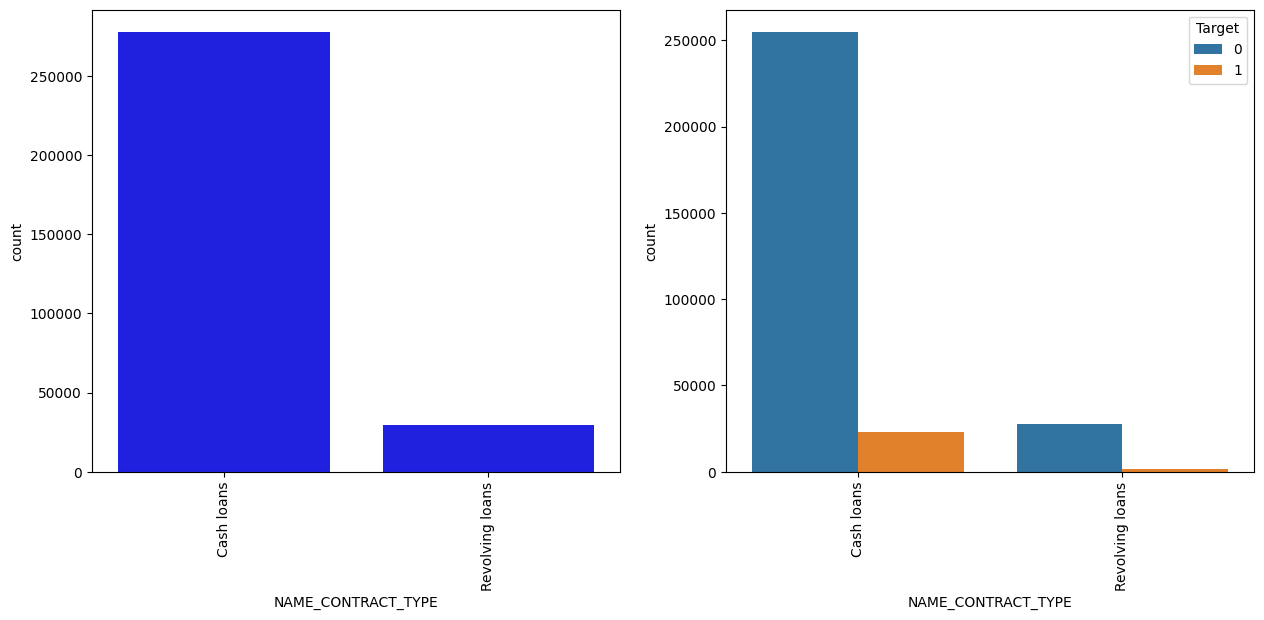


************************** CODE_GENDER **************************



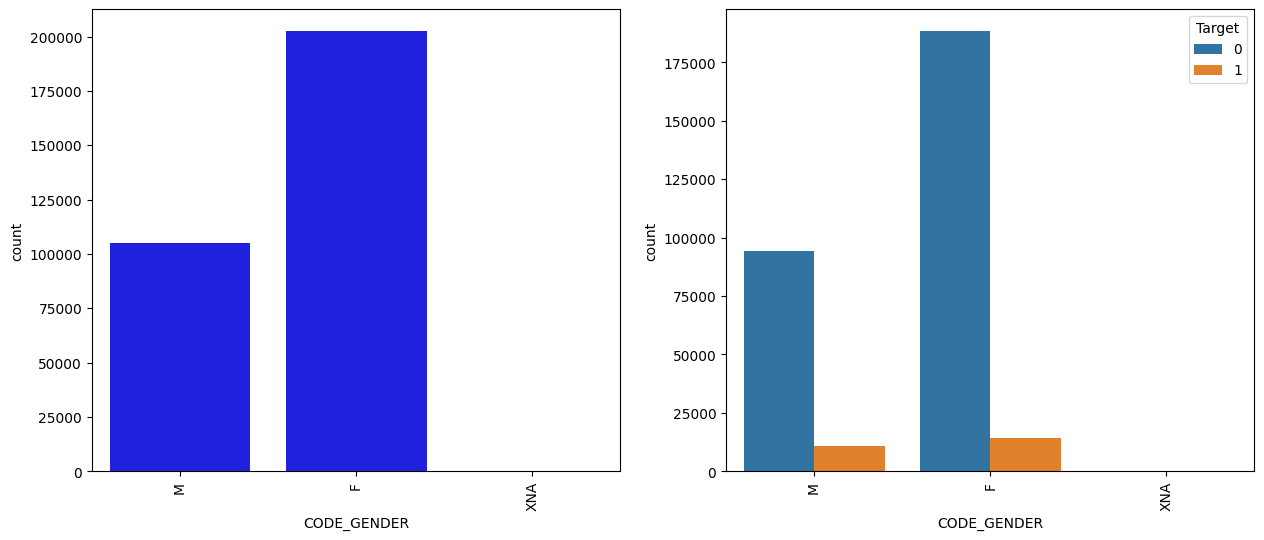


************************** FLAG_OWN_CAR **************************



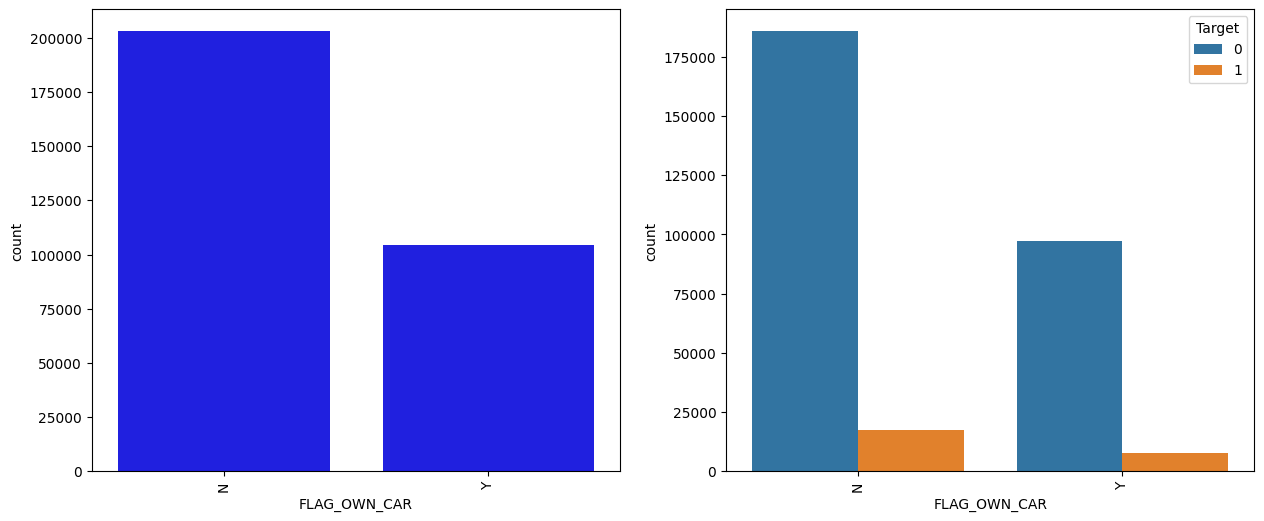


************************** FLAG_OWN_REALTY **************************



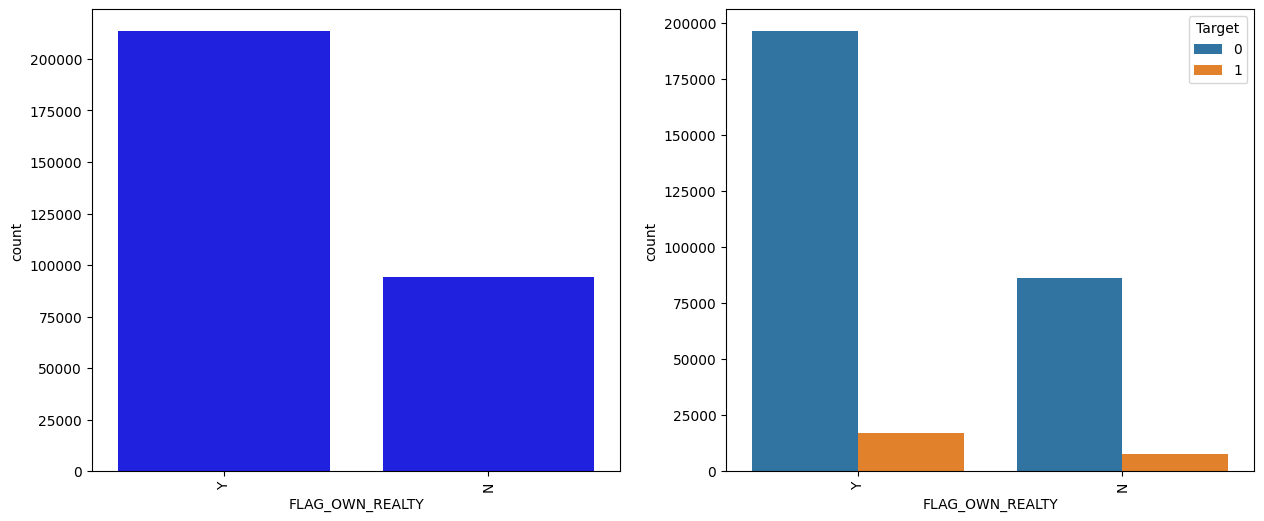


************************** NAME_TYPE_SUITE **************************



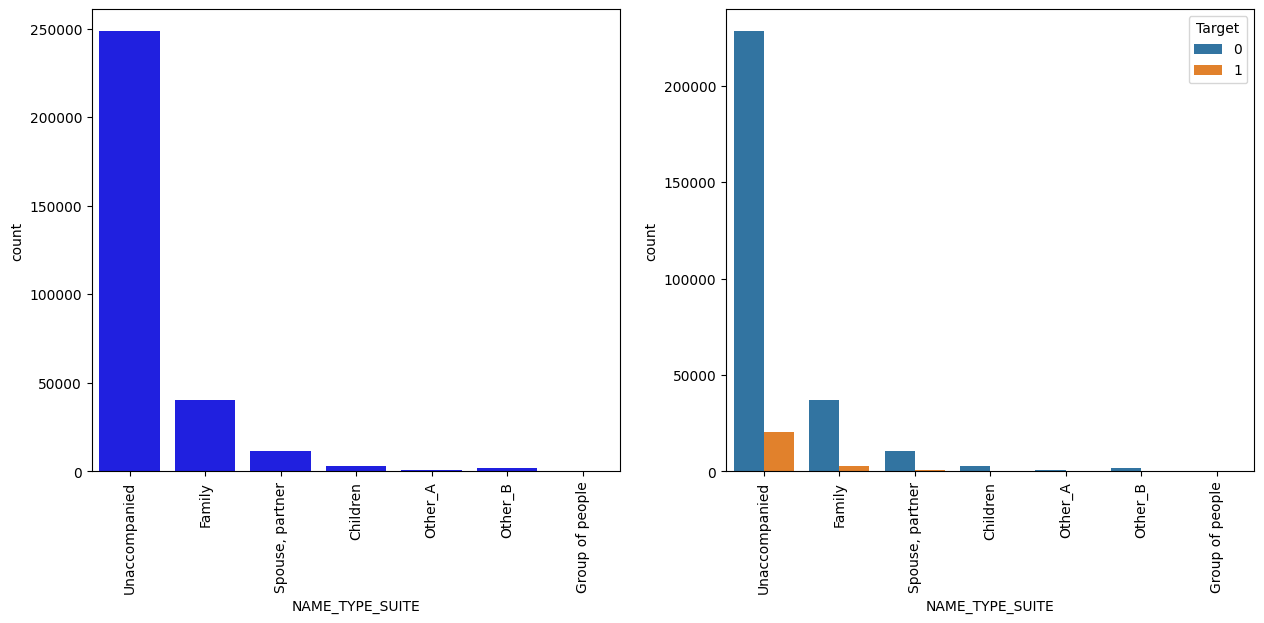


************************** NAME_INCOME_TYPE **************************



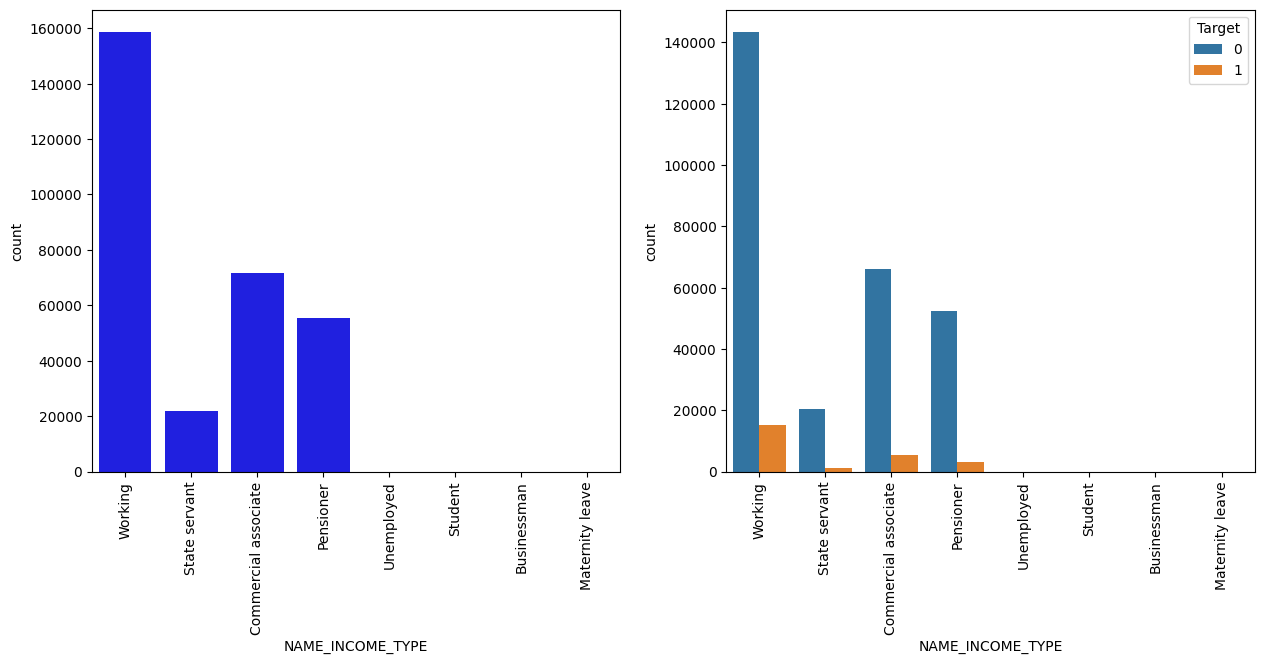


************************** NAME_EDUCATION_TYPE **************************



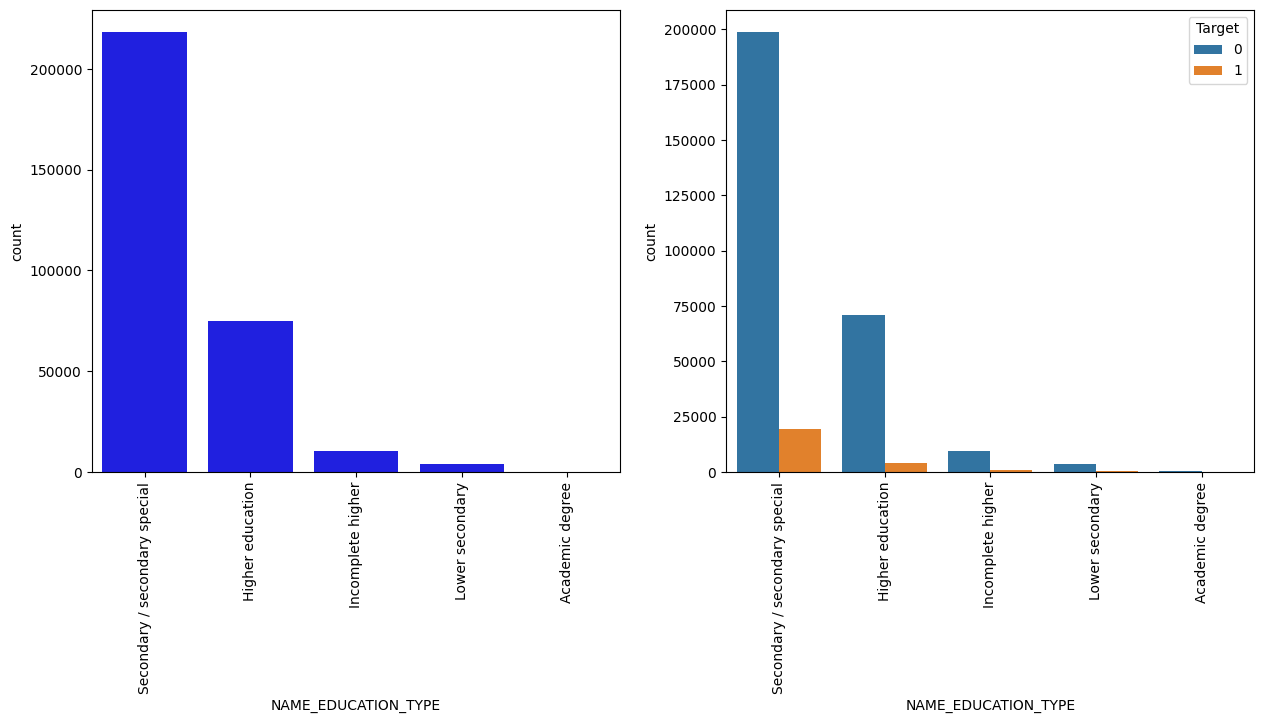


************************** NAME_FAMILY_STATUS **************************



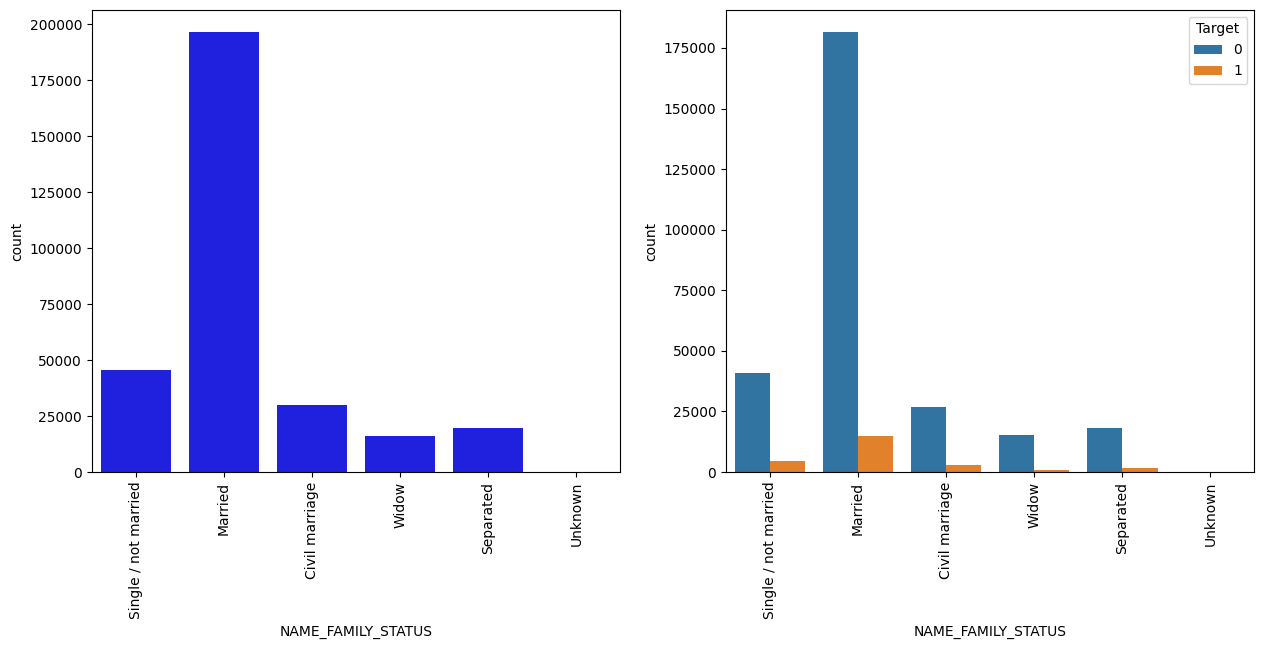


************************** NAME_HOUSING_TYPE **************************



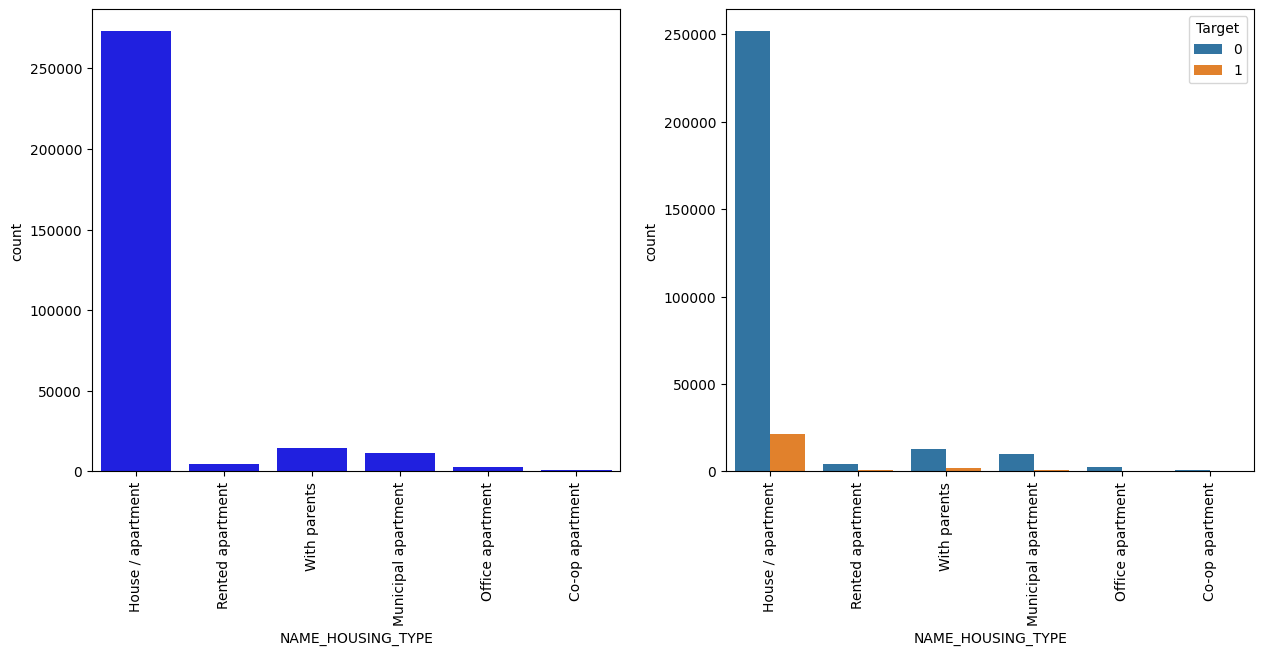


************************** OCCUPATION_TYPE **************************



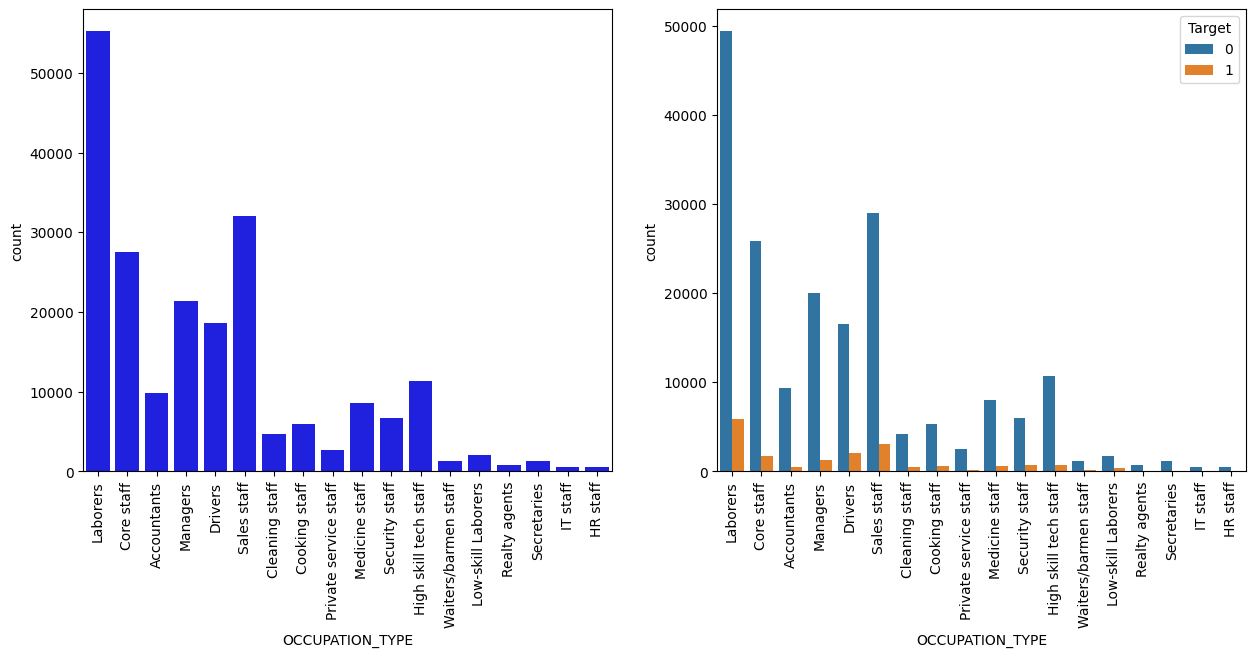


************************** WEEKDAY_APPR_PROCESS_START **************************



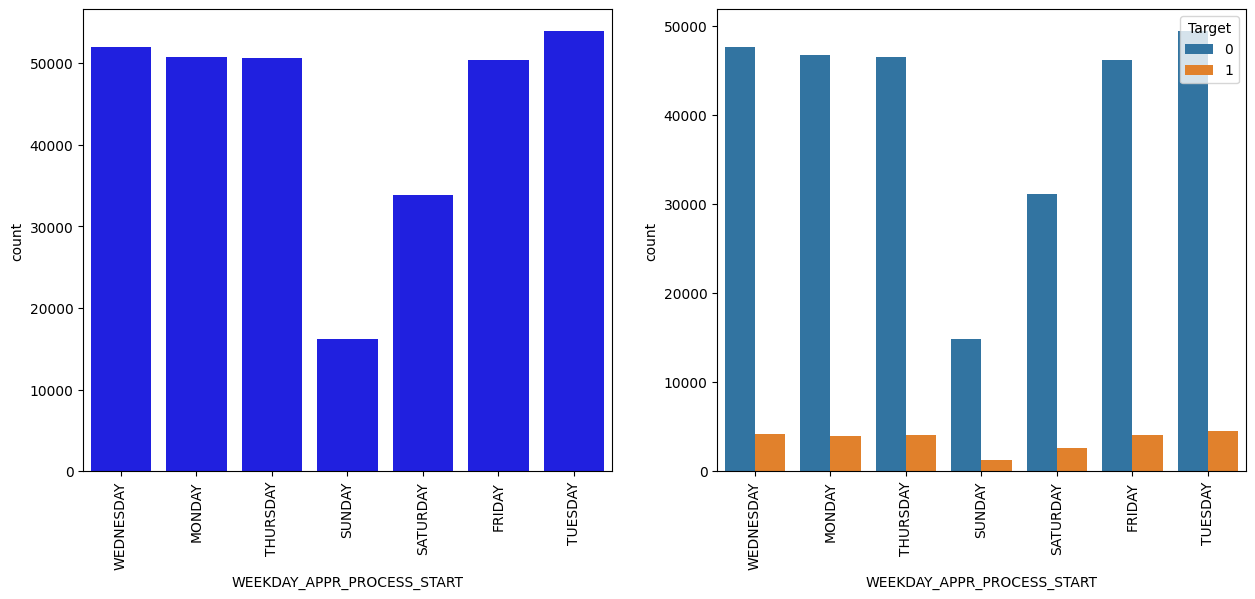


************************** ORGANIZATION_TYPE **************************



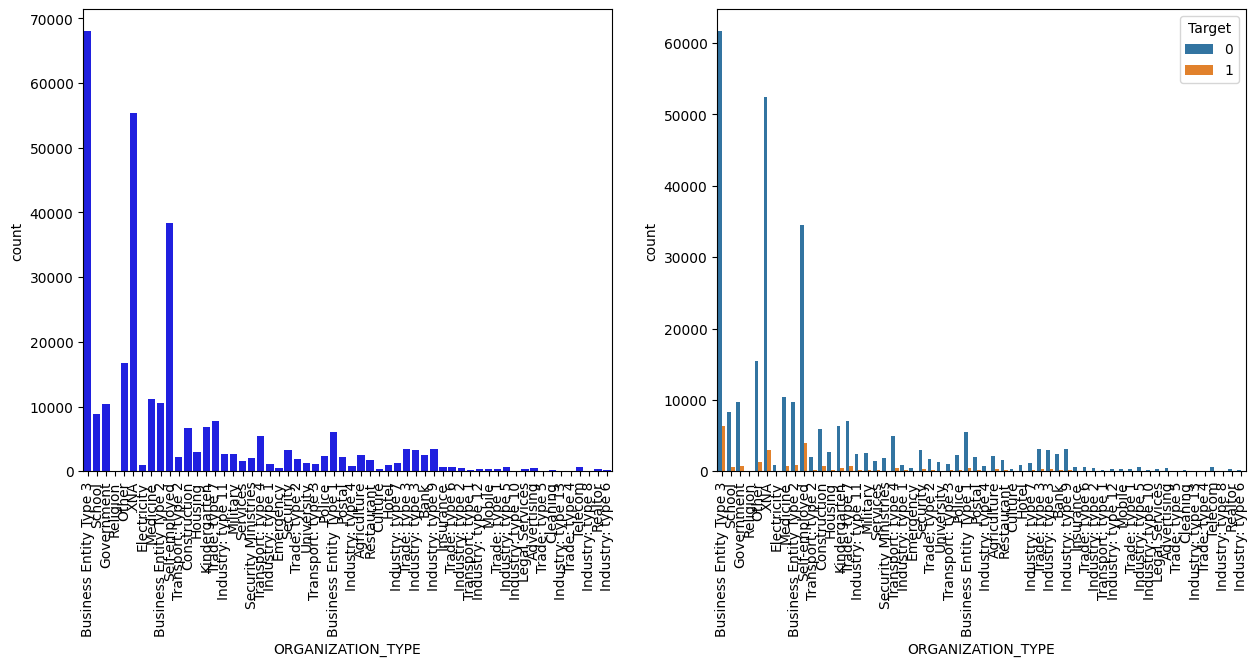


************************** FONDKAPREMONT_MODE **************************



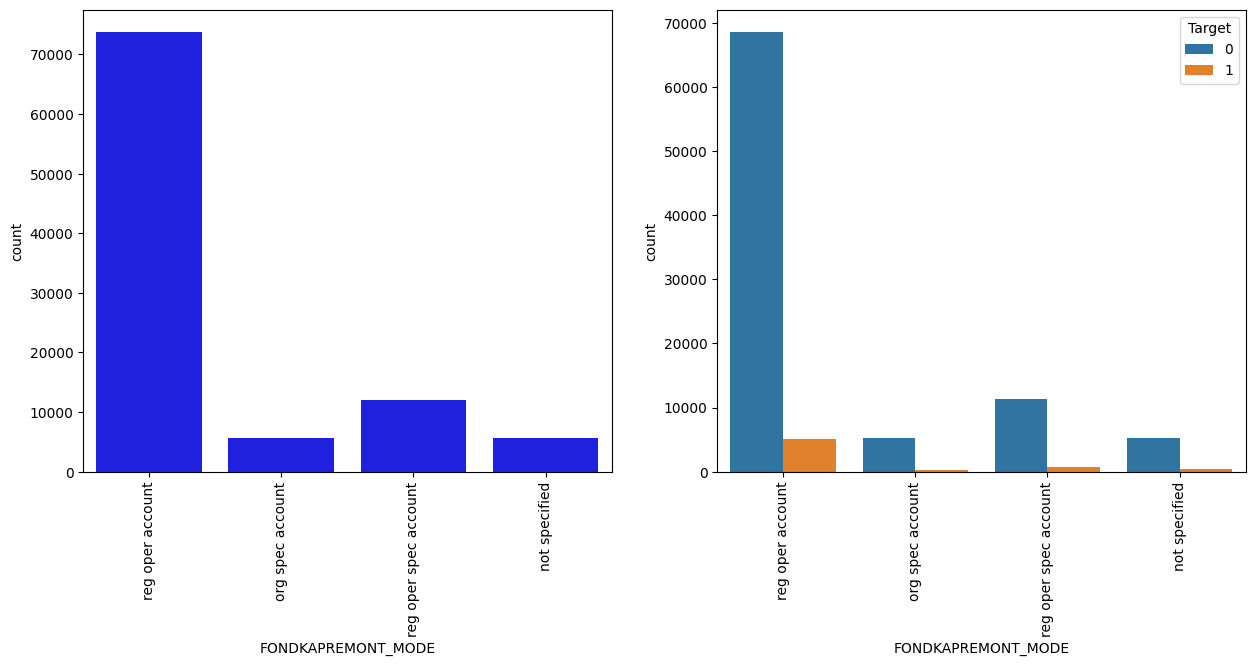


************************** HOUSETYPE_MODE **************************



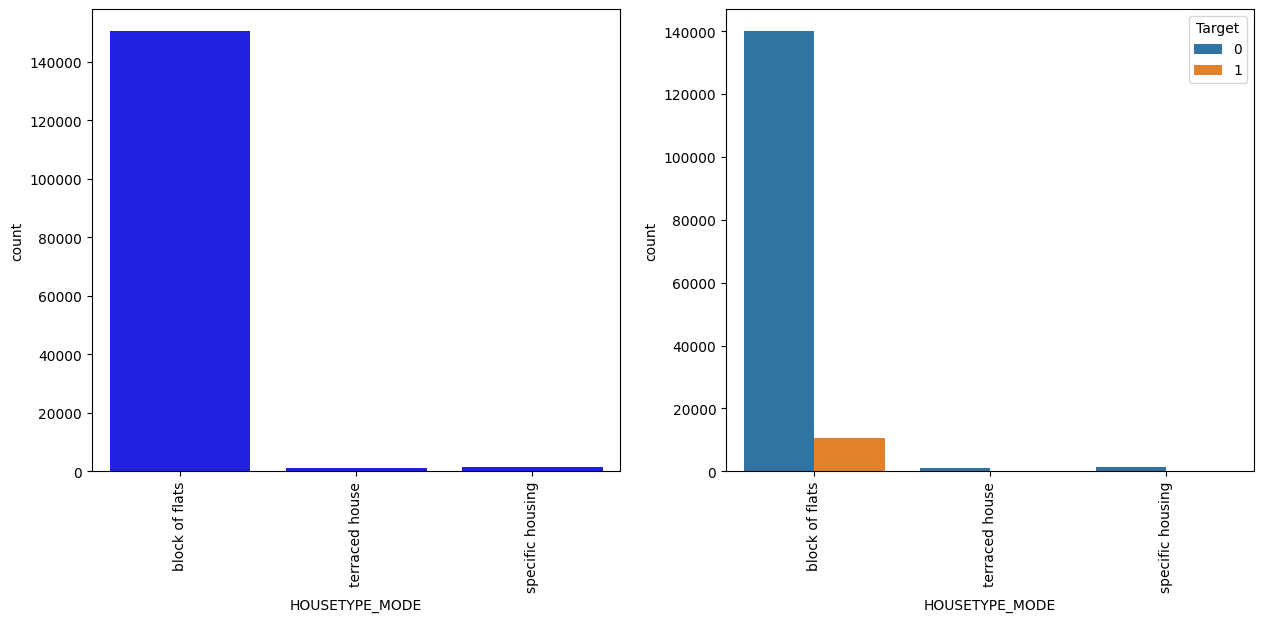


************************** WALLSMATERIAL_MODE **************************



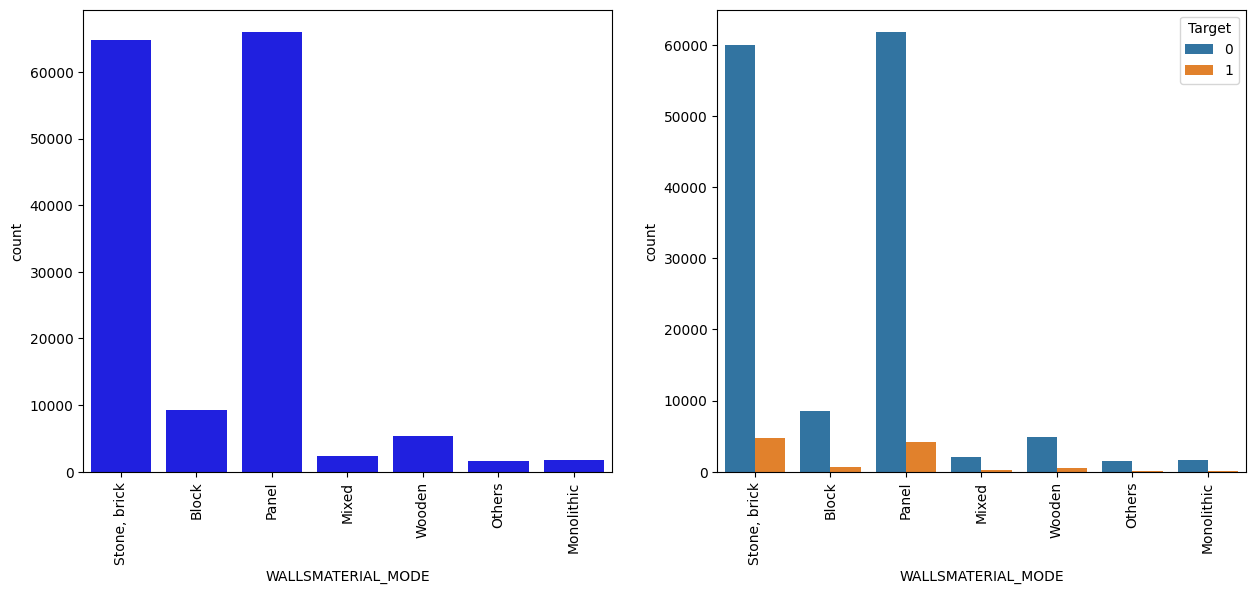


************************** EMERGENCYSTATE_MODE **************************



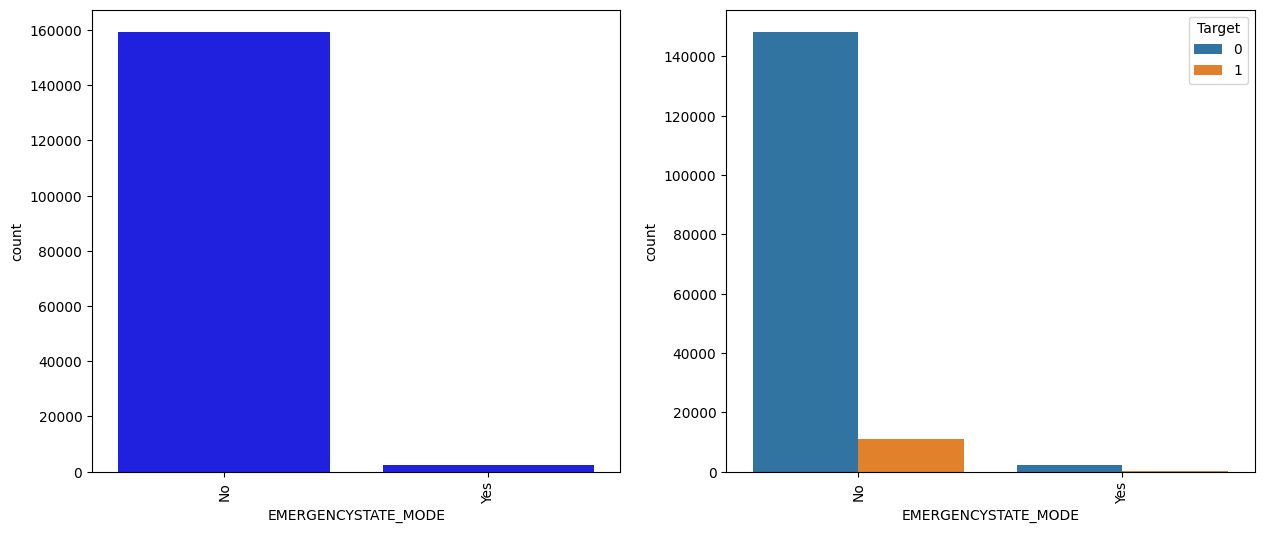

In [14]:
#col_names_cat = Categorical_df.columns
for i in range(len(Categorical_feature)):
    Bi_plot(Train_df, Categorical_feature[i])

#### Numerical features

In [15]:
#Get list of the numerical features
Numerical_df = Train_df.select_dtypes(include = ['float', 'int'])
Numerical_feature = list(Numerical_df.columns.drop('SK_ID_CURR'))

#### Correlation coefficient of numerical features with Target

In [16]:
correl_target = Train_df.corr()['TARGET'].sort_values(ascending = True)

# Print list of highly correlated variables with target
print('Most Positive Correlations:\n', correl_target.tail(15))
print('\n*********************************************')
print('\nMost Negative Correlations:\n', correl_target.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

*********************************************

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0

- The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_2, EXT_SOURCE_3, and EXT_SOURCE_1. According to the documentation, these features represent a "normalized score from external data source" that probably represents database with other algorithm results, while DAYS_BIRTH, DAYS_EMPLOYED, REGION_RATING_CLIENT, and DAYS_LAST_PHONE_CHANGE have the strongest positive correlations

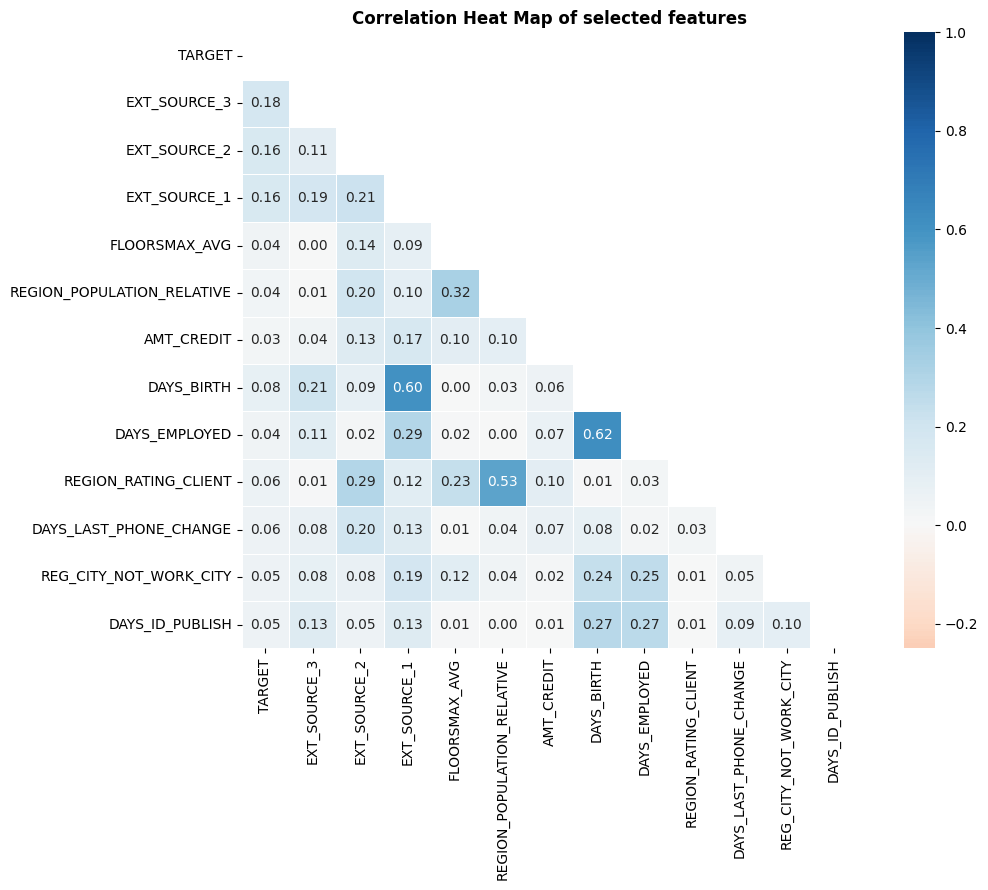

In [17]:
# create list of selected highly correlated variables with target selected variables
cor_list = ['TARGET','EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'FLOORSMAX_AVG',
            'REGION_POPULATION_RELATIVE', 'AMT_CREDIT','DAYS_BIRTH', 'DAYS_EMPLOYED', 'REGION_RATING_CLIENT', 
            'DAYS_LAST_PHONE_CHANGE', 'REG_CITY_NOT_WORK_CITY','DAYS_ID_PUBLISH']

# define the correlation matrix variable
cor_matrix = Train_df[cor_list].corr(method='pearson').abs()

# Remove the upper part of the heatmap
mask = np.triu(np.ones_like(cor_matrix, dtype=np.bool))

#visualize the heat map
plt.figure(figsize=(12, 8))
sns.heatmap(cor_matrix, mask = mask, fmt='.2f', center=0, cmap='RdBu', vmin=-0.25, vmax=1, annot=True, 
            linewidths=.5, square=True)
plt.title('Correlation Heat Map of selected features', fontweight='bold', size =12)
plt.show()

#### Distribution plots of selected numerical features and their relationships with the target feature

***Number of Children***


************************** CNT_CHILDREN **************************



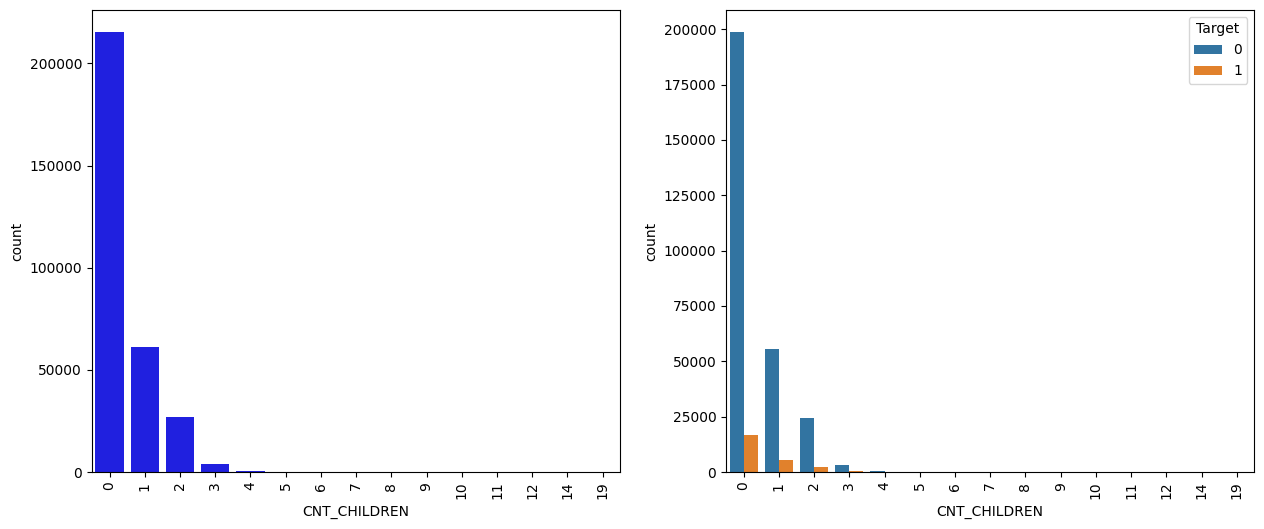

In [18]:
Bi_plot(Train_df, 'CNT_CHILDREN')

***Number of family members***


************************** CNT_FAM_MEMBERS **************************



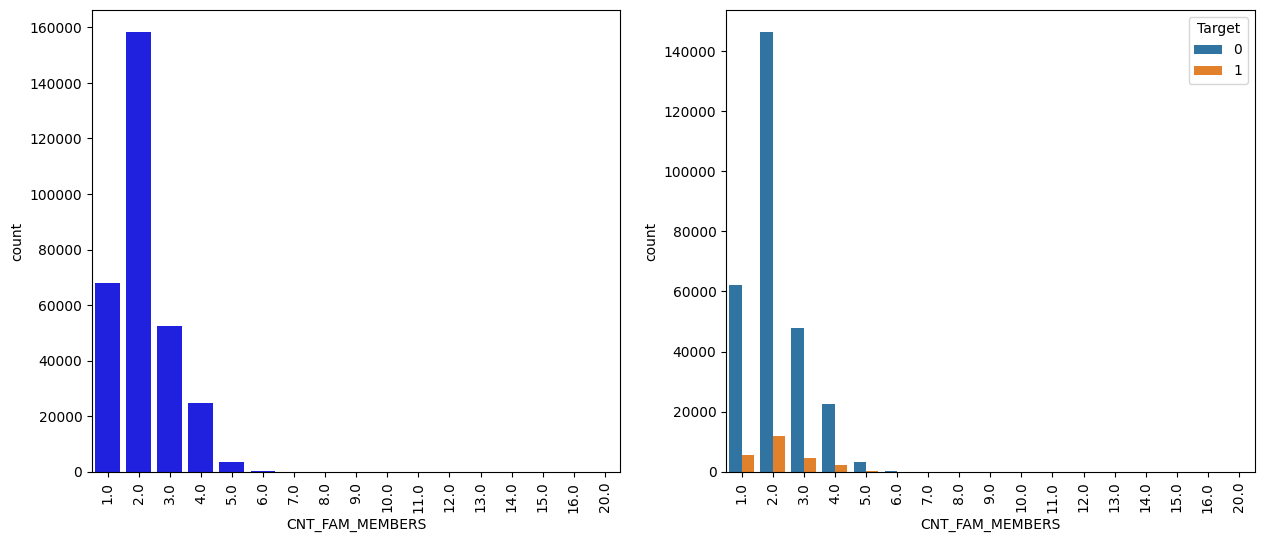

In [19]:
Bi_plot(Train_df, 'CNT_FAM_MEMBERS')

***Influence of Age group on repayment status***

In [20]:
def dist_plot(data, variable):
    '''Function that returns the districbution plots of a variable'''
    
    print("\n************************** {} **************************\n".format(variable))
    plt.figure(figsize = (6,4))
    
    # plot of paid loan
    sns.distplot(data.loc[data['TARGET'] == 0, variable], label = 'Target == 0')
    
    #unpaid loan
    sns.distplot(data.loc[data['TARGET'] == 1, variable], label = 'Target == 1')
    plt.legend(loc='upper right')
    plt.show()


************************** DAYS_BIRTH **************************



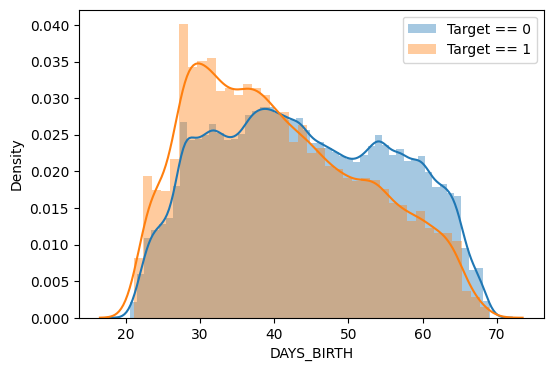

In [21]:
# Convert AGE from days to years
Train_df['DAYS_BIRTH'] = round(abs(Train_df['DAYS_BIRTH'])/365,2)
Test_df['DAYS_BIRTH'] = round(abs(Test_df['DAYS_BIRTH'])/365, 2)

dist_plot(Train_df, 'DAYS_BIRTH')

- The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation, this variable is likely going to be useful in a machine learning model because it does affect the target. Thus, there is a clear trend. This information shows that it is more likely that younger applicants won't repay their loans. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time by providing guidance or financial planning tips. 

Others


************************** AMT_INCOME_TOTAL **************************



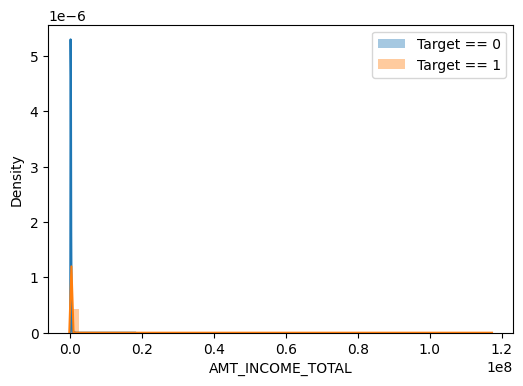


************************** DAYS_EMPLOYED **************************



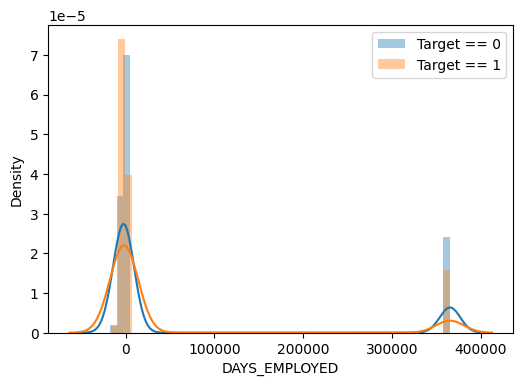


************************** AMT_CREDIT **************************



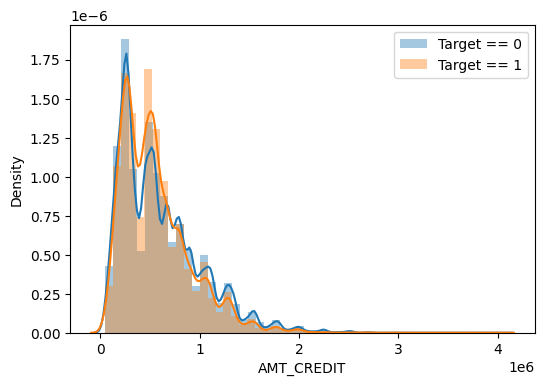


************************** EXT_SOURCE_1 **************************



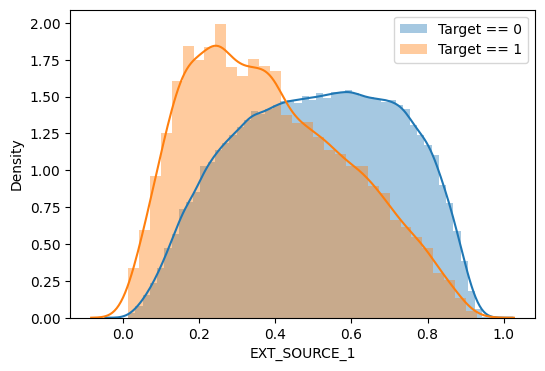


************************** EXT_SOURCE_2 **************************



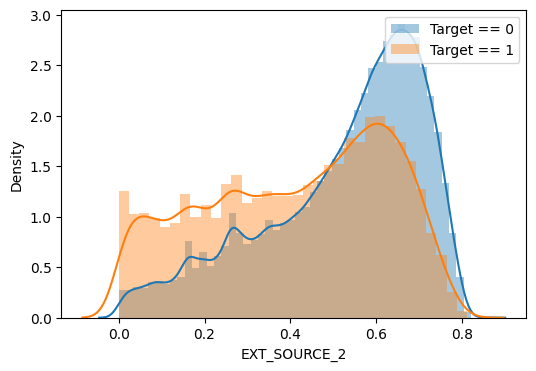


************************** EXT_SOURCE_3 **************************



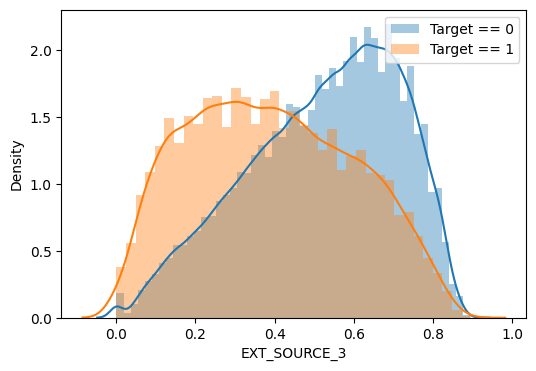

In [21]:
#create list of selected numerical variables
Num_list=['AMT_INCOME_TOTAL','DAYS_EMPLOYED','AMT_CREDIT','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

#plot
for i, feature in enumerate(Num_list):
    dist_plot(Train_df, feature)

- The external sources, especially sources 1 and 3, have huge negative impacts on loan repayments. EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature have some relationship to the likelihood of an applicant to repay a loan.

- The number of days of employment column (DAYS_EMPLOYED) has anomalous values of 365243 days (1000 years), which will be treated in the next section - Data preparation

#### Statistical summary

In [24]:
Train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,1.000020e+05,189145.500000,278202.000000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.000000e+00,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-2.522900e+04,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-1.791200e+04,-2760.000000,-1213.000000,-289.000000,3.652430e+05


## 5.0 Data Preparation and Feature Engineering

### 5.1 Data Cleaning

In [25]:
def special_characters(col):
    ''' Function that removes special characters in categorical features'''
    col = str(col).replace('-', '').replace('+', '').replace('/', ' ').replace(':', '_')
    col = str(col).upper()
    return col

# Train dataset
for col in Train_df[Categorical_feature]:
    Train_df[col] = Train_df[col].apply(lambda x : special_characters(x))
    
# Test dataset
for col in Test_df[Categorical_feature]:
    Test_df[col] = Test_df[col].apply(lambda x : special_characters(x))

In [26]:
# Remove erroneous and abnormal values

# delete XNA and unknown in gender type and family status, respectively
Train_df = Train_df[Train_df['CODE_GENDER'] != 'XNA'] # Gender
Train_df = Train_df[Train_df['NAME_FAMILY_STATUS'] != 'Unknown'] # family status

Test_df = Test_df[Test_df['CODE_GENDER'] != 'XNA'] # Gender
Test_df = Test_df[Test_df['NAME_FAMILY_STATUS'] != 'Unknown'] # family status

# replace days of employed with anomalous values with NAN
Train_df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True) # Train
Test_df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True) # Test

# replace erroneous values >30 in the OBS columns with NAN
Train_df['OBS_30_CNT_SOCIAL_CIRCLE'][Train_df['OBS_30_CNT_SOCIAL_CIRCLE']>=30] = np.nan # Train
Test_df['OBS_30_CNT_SOCIAL_CIRCLE'][Test_df['OBS_30_CNT_SOCIAL_CIRCLE']>=30] = np.nan # Test
Train_df['OBS_60_CNT_SOCIAL_CIRCLE'][Train_df['OBS_60_CNT_SOCIAL_CIRCLE']>=30] = np.nan # Train
Test_df['OBS_60_CNT_SOCIAL_CIRCLE'][Test_df['OBS_60_CNT_SOCIAL_CIRCLE']>=30] = np.nan # Test

#### Treatment of Missing Data

In [27]:
# Drop columns with more than 60% missing value threshold
# get list of columns with NA above threshold in the train set
Train_above = Train_df[Train_df.columns[Train_df.isna().sum()/len(Train_df) > 0.6]]
cols_above = list(Train_above.columns)#.tolist()

# remove columns above threshold
#Train data
Train_df.drop(cols_above, axis = 1, inplace = True)
# Test data
Test_df.drop(cols_above, axis = 1, inplace = True)
#[Test_df.columns[Test_df.isna().sum()/len(Test_df) < 0.6]]
print(Train_df.shape, Test_df.shape)

(307507, 106) (48744, 105)


Functions for cleaning

In [28]:
# Numerical features
# fill NAN values in numerical columns with their median values
def replace_median(df, col):
    df[col] = df[col].fillna(df[col].median())
    
# categorical features

# replace "NAN" in categorical data with np.nan
def df_nan(df, col):
    df[col] = df[col].replace('NAN', np.nan)
    return df[col]

# fill NAN values in categorical columns with mode
def replace_mode(df, col):
    df[col] = df[col].fillna(df[col].mode()[0])

Train data

In [29]:
# create list and fill columns with NA
# numeric

Numerical_df = Train_df.select_dtypes(include = ['float', 'int'])
Num_train = list(Numerical_df.columns.drop(['SK_ID_CURR', 'TARGET']))

Num_NA = Numerical_df.isnull().sum() != 0
Num_NA_feat = Numerical_df.columns[Num_NA].tolist()

#categorical
Categorical_df = Train_df.select_dtypes(include = 'object')
Cat_NA_feat = list(Categorical_df.columns)

In [30]:
for i in range(len(Num_NA_feat)):
    replace_median(Numerical_df, Num_NA_feat[i])

for i in range(len(Cat_NA_feat)):
    df_nan(Categorical_df, Cat_NA_feat[i])
    

for i in range(len(Cat_NA_feat)):
    replace_mode(Categorical_df, Cat_NA_feat[i])
    
Num_cols = Numerical_df.columns
Cat_cols = Categorical_df.columns

Train_clean = Train_df.copy()

Train_clean[Num_cols] = Numerical_df[Num_cols]
Train_clean[Cat_cols] = Categorical_df[Cat_cols]

# check the total missing NA in the train dataset
Train_clean.isnull().sum().sum()

0

Test data

In [31]:
# create list and fill columns with NA
# numeric
Numerical_test = Test_df.select_dtypes(include = ['float', 'int'])
#Num_test = list(Numerical_test.columns.drop('SK_ID_CURR'))

Num_NA_Test = Numerical_test.isnull().sum() != 0
Num_NA_feaTest = Numerical_test.columns[Num_NA_Test].tolist()

for i in range(len(Num_NA_feaTest)):
    replace_median(Numerical_test, Num_NA_feaTest[i])

#categorical
Cat_test = Test_df.select_dtypes(include = 'object')
Cat_NA_Test = list(Cat_test.columns)
   

for i in range(len(Cat_NA_Test)):
    df_nan(Cat_test, Cat_NA_feat[i])
    
for i in range(len(Cat_NA_Test)):
    replace_mode(Cat_test, Cat_NA_Test[i])
    
Num_col = Numerical_test.columns
Cat_col = Cat_test.columns

Test_clean = Test_df.copy()

Test_clean[Num_col] = Numerical_test[Num_col]
Test_clean[Cat_col] = Cat_test[Cat_col]

# check the total missing NA in the train dataset
Test_clean.isnull().sum().sum()

0

In [31]:
Train_clean.shape, Test_clean.shape

((307507, 106), (48744, 105))

### 5.2 Create new features

In [32]:
# Train set
Train_clean['PROPORTION_LIFE_EMPLOYED'] = Train_clean['DAYS_EMPLOYED'] / Train_clean['DAYS_BIRTH']
Train_clean['CREDIT_INCOME_RATIO'] = Train_clean['AMT_INCOME_TOTAL']/Train_clean['AMT_CREDIT']
Train_clean['PAYMENT_RATE'] = Train_clean['AMT_CREDIT']/Train_clean['AMT_ANNUITY']
Train_clean['INCOME_FAMILY_SIZE'] = Train_clean['AMT_INCOME_TOTAL']/Train_clean['CNT_FAM_MEMBERS']


# Test set
Test_clean['PROPORTION_LIFE_EMPLOYED'] = Test_clean['DAYS_EMPLOYED'] / Test_clean['DAYS_BIRTH']
Test_clean['CREDIT_INCOME_RATIO'] = Test_clean['AMT_INCOME_TOTAL']/Test_clean['AMT_CREDIT']
Test_clean['PAYMENT_RATE'] = Test_clean['AMT_CREDIT']/Test_clean['AMT_ANNUITY']
Test_clean['INCOME_FAMILY_SIZE'] = Test_clean['AMT_INCOME_TOTAL']/Test_clean['CNT_FAM_MEMBERS']

print(Train_clean.shape, Test_clean.shape)

(307507, 110) (48744, 109)


### 5.3 Feature Selection

#### Pearson correlation coefficient
 - Remove highly collinear features to avoid overfitting, reduce dimenesion, long computational time, and increasing model variance
 - Multicollinearity occurs where there is a dependency between the independent features.
 - keep only one of the collinear features for modeling

In [33]:
def collinearity(df, threshold):
    correlated_cols = set()
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range (i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                col_name = corr_matrix.columns[i]
                correlated_cols.add(col_name)
    return correlated_cols      

# get list of highly collinear numerical features using a 0.8 correlation threshold
list_drop = collinearity(Train_clean[Num_train], 0.8)
list_drop = collinearity(Train_clean, 0.8)

In [34]:
# drop collinear features in Train data
Train_clean.drop(list_drop, axis = 1, inplace = True)

# drop collinear features in Test data
Test_clean.drop(list_drop, axis = 1, inplace = True)

print(Train_clean.shape, Test_clean.shape)

(307507, 80) (48744, 79)


#### Save Selected Features for Machine Learning Modeling

In [35]:
pickle.dump(Train_clean, open("Train_clean_50N.p", "wb"))
pickle.dump(Test_clean, open("Test_clean_50N.p", "wb"))

In [36]:
# Save the cleaned train and test data for machine learning modeling
Train_clean.to_csv("Train_clean_50N.csv", index = False)
Test_clean.to_csv("Test_clean_50N.csv", index = False)

## 6.0 Machine Learning Modeling and Model Selection

In [37]:
# Reload the data
Train_clean = pickle.load(open("Train_clean_50N.p", "rb"))
Test_clean = pickle.load(open("Test_clean_50N.p", "rb"))

### 6.1 Data sub-sampling
- The number of observation is heavy and result in lots of computational time. Hence, I randomly selected 50,000 observations that capture the distribution of target class-ratio.

In [38]:
# Distribution of the initial target variable
Train_clean['TARGET'].value_counts(normalize = True)

0    0.91927
1    0.08073
Name: TARGET, dtype: float64

In [39]:
# randomly select 50000 samples for modeling because of the large observation size
Train_sample = Train_clean.sample(50000, random_state = 42)
Train_sample.shape

(50000, 80)

In [40]:
# Distribution of the target variable after random sampling
Train_sample['TARGET'].value_counts(normalize = True)

0    0.91898
1    0.08102
Name: TARGET, dtype: float64

Stratified sub_sampling on the TARGET worked - the proportions of 1 and 0 of train and test are identical to those of the original set. The original imbalance of the dataset was well preserved.

### 6.2.1 Pre-processing

In [46]:
# drop SK_ID_CURR
Train_model = Train_sample.copy()

**Prepare input and output for Train datasets**

In [48]:
# Splitting the data into input (X) and output (y) features
X = Train_model.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
y = Train_model['TARGET']
X.shape, y.shape

((50000, 78), (50000,))

**Split Train dataset for modeling**

In [49]:
# Assign 20% of the dataset to the testing part and 80% of the dataset to the training part.

def Dataset(X, y):       
    # split the data into 80% train and 30% test set
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0) 
    
    return X_train, y_train, X_val, y_val 

In [51]:
X_train, y_train, X_val, y_val = Dataset(X, y)

print("Train data\t:", X_train.shape, y_train.shape)
print("Validation test data\t:", X_val.shape, y_val.shape)

Train data	: (40000, 78) (40000,)
Validation test data	: (10000, 78) (10000,)


#### List of variables

In [52]:
# get column list for categorical and numerical variables
Num_features = list(X_val.select_dtypes(include = ['float', 'int']).columns)
Cat_features = list(X_val.select_dtypes(include = 'object').columns)
All_features = list(X_val.columns)

**Standardization**

- We have a binary imbalanced class distribution of the dependent variable - Target (92% 0 and 8% 1), so I use SMOTE (synthetic minority oversampling technique) to handle this imbalance to avoid bias classification and improve the perfomance evaluation metrics. SMOTE oversampling uses a nearest neighbours algorithm to randomly generate new and synthetic data of the minority class in the training dataset by replicating them between the chosen point and its neighbour only . This can balance the class distribution but does not provide any additional information to the model
(see https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification) and (https://imbalanced-learn.org/stable/)


- I used randomly trainded data using both MinMaxScaler and RobustScalar to standardize the numerical variables and selected the one that gives the best evaluation metric perfomance from several runs

#### Pipeline function

In [51]:
# Standardize data and instantiate pipeline
def pipeline(classifier):
    '''Function that standardize and instantiate pipeline for the classification algorithm'''
    
    #numeric_transformer = Pipeline(steps = [('scaler', RobustScaler())]) 
    numeric_transformer = Pipeline(steps = [('scaler', MinMaxScaler())])
    categorical_transformer = Pipeline(steps = [('encoder', OneHotEncoder(handle_unknown="ignore"))])
    
    model_preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, Num_features),
        ("cat", categorical_transformer, Cat_features)])
    
    Pipe =  imbpipeline(steps=[("preprocessor", model_preprocessor), ("smote", SMOTE()), ("classifier", classifier)])
    
    return Pipe

### 6.2 Model training and selection
- I trained four supervised classification models - 
        1. LogisticRegression
        2. Random Forest Classifier
        3. XGBoost, 
        4. LGBM, and 
        5. Dummy Classifier as a baseline model    


- I used stratifiedKfold for the cross validation to handle the class imbalancing


- Lastly, since we have an highly imbalanced target binary-class, using accuracy as metric performance evaluation may be misleading because of it's bias towards the majority class. Hence, I used the auc score, ROC-AUC curves, and confusion matrix to compare the actual classses and have clearer pictures of the performances of the algorithms.

**Functions for performance evaluation**
 - Evaluation metrics, confusion matrix, and roc_auc curves

In [52]:
# Evaluation metrics
def Evaluate_metrics(y_test, y_pred, y_proba):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1_score = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    return {'auc': round(auc, 2), 'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 
            'F1_score': round(F1_score, 2)}

# Confusion matrix
def cf_matrix_plot(y_test, y_pred, name):
    plt.figure(figsize=(5,5))
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    ax1 = sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.title("Confusion Matrix of " + name, fontweight='bold', fontsize=12)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')    
    plt.savefig('confusion_matrix.png')
    plt.show()
    
# ROC_AUC Curve
def ROC_AUC_Curve(y_test, y_proba, name):
    fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_proba)
    # plot no-skill curve
    plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
    
    # plot the ROC_AUC curve
    plt.plot(fpr, tpr, label = name + ' : %0.4f' % roc_auc + ' (AUC)') 

    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("ROC Curve Analysis", fontweight='bold', fontsize=12)
    plt.legend(prop={'size':10}, loc='lower right')
    plt.savefig('roc_auc_curve.png')
    plt.show()

### Start Experimental Tracking - MlFlow
- The classification perfomance metrics, hyperparameters, and plots such as ROC-AUC curve and confusion matrix of each runs of the models are all tracked and registered using the databricks mlflow.


- I also display representative of these parameters and plots in the notebook for reference purpose but they are esentially stored in the local mlflow registry(port) of my computer


- The metrics and parameters of each runs were compared and the best model and its parameters selected for predictions, interpretation, and deployment

### 6.2.2 Baseline models 
- modeling with default parameters

In [91]:
#mlflow.set_tracking_uri("sqlite:///mlflow.db")
server_uri = 'http://127.0.0.1:5000'
mlflow.set_tracking_uri(server_uri)
mlflow.set_experiment('Base_models_50N')

<Experiment: artifact_location='mlflow-artifacts:/393407342734351331', creation_time=1676962714171, experiment_id='393407342734351331', last_update_time=1676962714171, lifecycle_stage='active', name='Base_models_50N', tags={}>

In [54]:
def base_param(classifier, model_name):
    start = time.time()

    # instantiate the classifier
    model = pipeline(classifier)
    
    # fit the training model
    model.fit(X_train, y_train)    
    
    # prediction on the training data
    y_pred_train = model.predict(X_train)    
    # predict the probability of the output and keep only positive outcomes on the train data
    y_proba_train = model.predict_proba(X_train)[:, 1]
        
    # Prediction on the validation data
    y_pred_val = model.predict(X_val)
    # predict the probability of the output and keep only positive outcomes
    y_proba_val = model.predict_proba(X_val)[:, 1]

    stop = time.time()
    
    Training_Time = np.round((stop - start)/60, 2)

    # performance metrics on training data
    score_metrics_train = Evaluate_metrics(y_train, y_pred_train, y_proba_train)
    
    # performance metrics on validation data
    score_metrics_val = Evaluate_metrics(y_val, y_pred_val, y_proba_val)
    
    # estimate the roc_auc score and confusion matrix on the validation data
    roc_auc = ROC_AUC_Curve(y_val, y_proba_val, model_name)
    cf = cf_matrix_plot(y_val, y_pred_val, model_name)
        
    # Start MLflow
    with mlflow.start_run(run_name = model_name):
        
        # Track metrics
        for metric_train in score_metrics_train:
            mlflow.log_metric(metric_train, score_metrics_train[metric_train])     
            
        for metric_val in score_metrics_val:
            mlflow.log_metric(metric_val, score_metrics_val[metric_val]) 
            
        mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
        mlflow.log_artifact("roc_auc_curve.png", "roc_auc_curve")
            
        mlflow.log_metric("Training_time", Training_Time)
        
        # save the model
        mlflow.sklearn.log_model(model, "model_name")
        
    print('Evaluation_metrics on train data:', score_metrics_train)
    print('Evaluation_metrics on validation data:', score_metrics_val)
    print('Training Time:', Training_Time)           
    mlflow.end_run()

#### Dummmy classifier

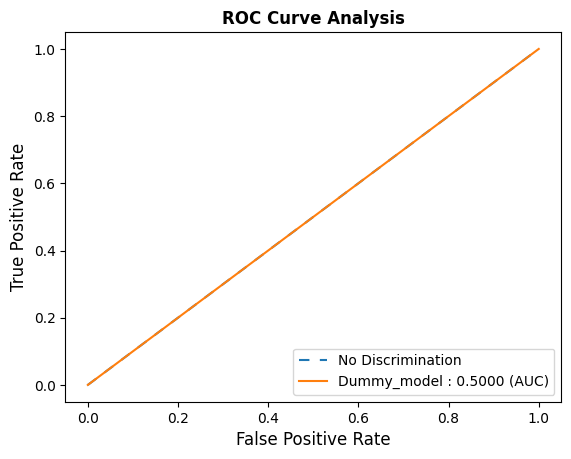

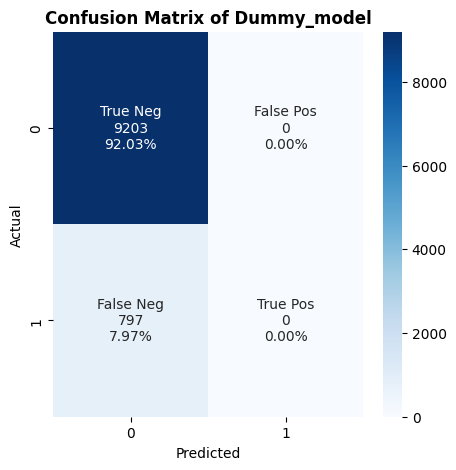

Evaluation_metrics on train data: {'auc': 0.5, 'accuracy': 0.92, 'precision': 0.0, 'recall': 0.0, 'F1_score': 0.0}
Evaluation_metrics on validation data: {'auc': 0.5, 'accuracy': 0.92, 'precision': 0.0, 'recall': 0.0, 'F1_score': 0.0}
Training Time: 0.03


In [55]:
Dummy_base = base_param(DummyClassifier(), "Dummy_model")
Dummy_base

***Logistic Regression***

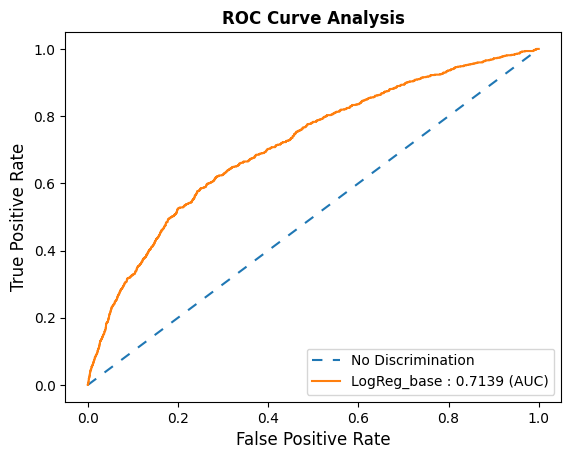

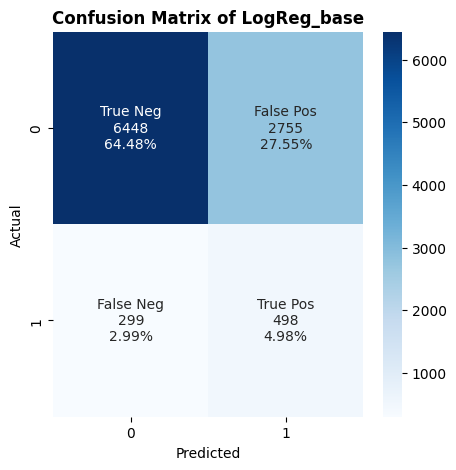

Evaluation_metrics on train data: {'auc': 0.74, 'accuracy': 0.7, 'precision': 0.16, 'recall': 0.65, 'F1_score': 0.26}
Evaluation_metrics on validation data: {'auc': 0.71, 'accuracy': 0.69, 'precision': 0.15, 'recall': 0.62, 'F1_score': 0.25}
Training Time: 0.08


In [56]:
Lr_base = base_param(LogisticRegression(), "LogReg_base")
Lr_base

***LGBM (Light Gradient Boosting Model) Classifier***

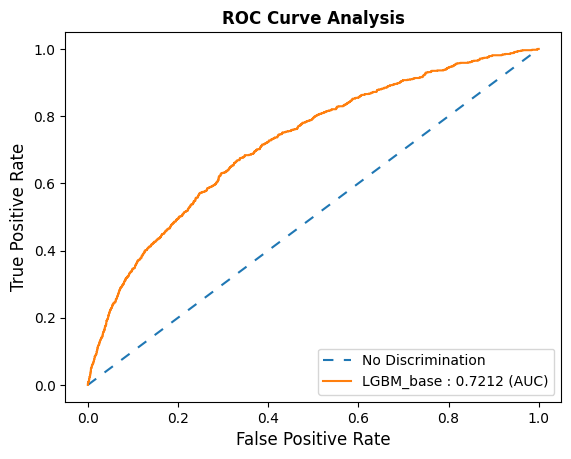

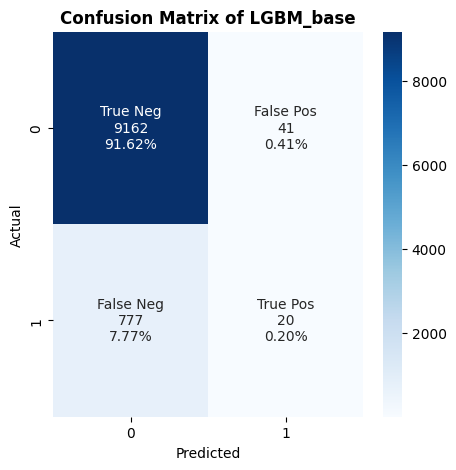

Evaluation_metrics on train data: {'auc': 0.84, 'accuracy': 0.92, 'precision': 0.7, 'recall': 0.05, 'F1_score': 0.1}
Evaluation_metrics on validation data: {'auc': 0.72, 'accuracy': 0.92, 'precision': 0.33, 'recall': 0.03, 'F1_score': 0.05}
Training Time: 0.08


In [57]:
LGBM_base = base_param(LGBMClassifier(), "LGBM_base")
LGBM_base

***Random Forest***

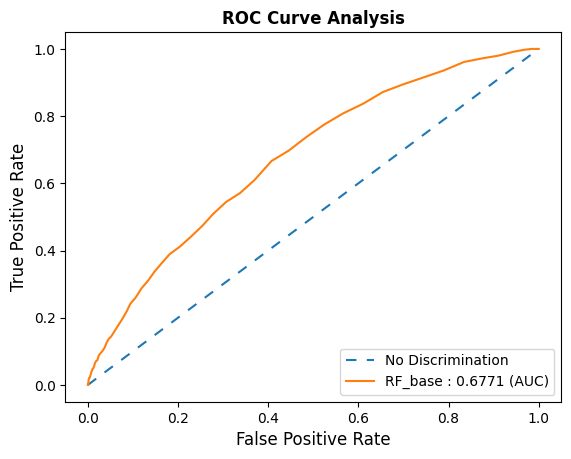

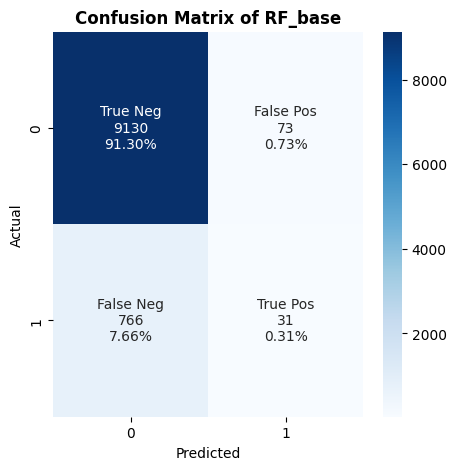

Evaluation_metrics on train data: {'auc': 1.0, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'F1_score': 1.0}
Evaluation_metrics on validation data: {'auc': 0.68, 'accuracy': 0.92, 'precision': 0.3, 'recall': 0.04, 'F1_score': 0.07}
Training Time: 0.81


In [58]:
RF_base = base_param(RandomForestClassifier(), "RF_base")
RF_base

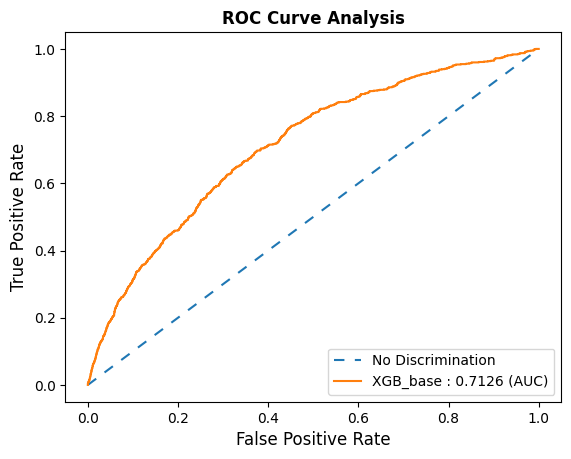

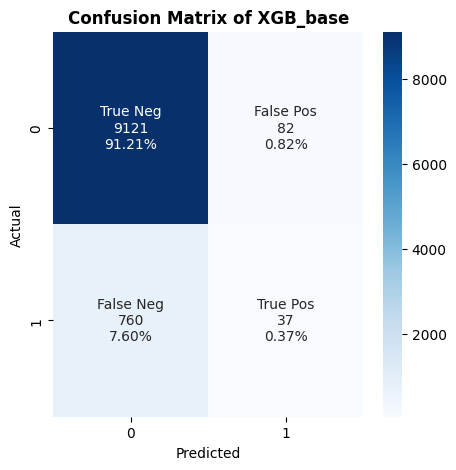

Evaluation_metrics on train data: {'auc': 0.95, 'accuracy': 0.94, 'precision': 0.94, 'recall': 0.26, 'F1_score': 0.4}
Evaluation_metrics on validation data: {'auc': 0.71, 'accuracy': 0.92, 'precision': 0.31, 'recall': 0.05, 'F1_score': 0.08}
Training Time: 0.64


In [59]:
XGB_base = base_param(XGBClassifier(), "XGB_base")
XGB_base

### 6.2.3 Hyperparameter optimization
- I used RandomizedSearchCV for hyperparameter tuning because of its fast training time over GridSearchCV in large dataset

In [60]:
mlflow.set_experiment('optimized_models_50N')

2023/02/21 08:01:01 INFO mlflow.tracking.fluent: Experiment with name 'optimized_models_50N' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/972496780191971594', creation_time=1676962861235, experiment_id='972496780191971594', last_update_time=1676962861235, lifecycle_stage='active', name='optimized_models_50N', tags={}>

***Logistic Regression***

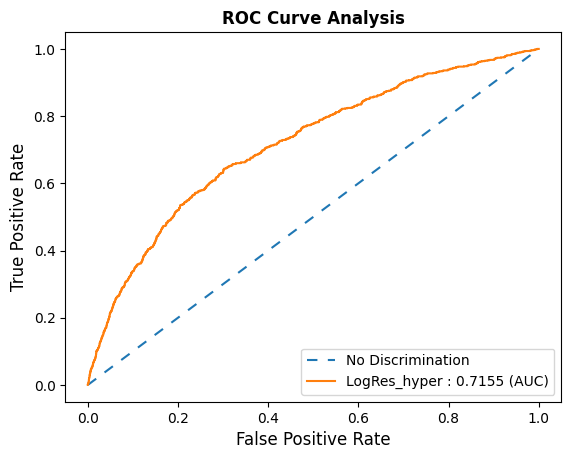

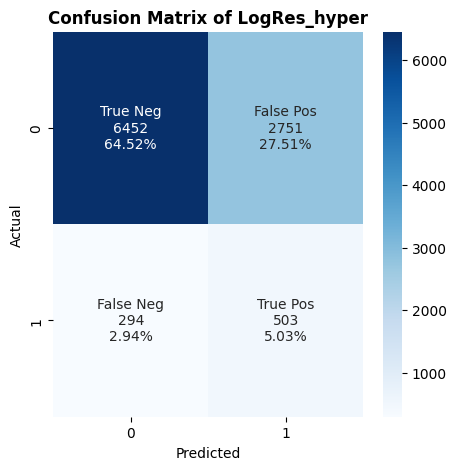

Evaluation_metrics on train data: {'auc': 0.74, 'accuracy': 0.7, 'precision': 0.16, 'recall': 0.65, 'F1_score': 0.26}
Evaluation_metrics on validation data: {'auc': 0.72, 'accuracy': 0.7, 'precision': 0.15, 'recall': 0.63, 'F1_score': 0.25}
Training Time: 2.43


In [61]:
param_LR = {'classifier__penalty': ['l1','l2'],   
           'classifier__C': [0.25, 0.5, 0.75, 1],
           'classifier__max_iter': [10, 50, 100, 500]}

splitter = StratifiedKFold(n_splits=3,shuffle=True,random_state=0)

start = time.time()
    
LogRes_opt  = pipeline(LogisticRegression())
    
cv_LogRes = RandomizedSearchCV(estimator=LogRes_opt, param_distributions=param_LR, n_jobs= -1, 
                                  cv=splitter, verbose=0, n_iter = 100)  
    
cv_LogRes.fit(X_train, y_train)
    
# make predictions on the train dataset
y_pred_train = cv_LogRes.predict(X_train)
    
# predict roc_auc from probabilities and keep positive outcomes only
yprob_train = cv_LogRes.predict_proba(X_train)[:, 1]
    
# make predictions on the validation dataset
y_pred_val = cv_LogRes.predict(X_val)
    
# predict roc_auc from probabilities and keep positive outcomes only
yprob_val = cv_LogRes.predict_proba(X_val)[:, 1]
    
stop = time.time()
    
Training_Time = np.round((stop - start)/60, 2)
    
# performance metrics on training data
score_metrics_train = Evaluate_metrics(y_train, y_pred_train, yprob_train)
    
# performance metrics on validation data
score_metrics_val = Evaluate_metrics(y_val, y_pred_val, yprob_val)
    
# estimate the roc_auc score and confusion matrix on the validation data
ROC_AUC_Curve(y_val, yprob_val, "LogRes_hyper")
cf_matrix_plot(y_val, y_pred_val, "LogRes_hyper") 
    

# Start MLflow
with mlflow.start_run(run_name = "LogRes_hyper"):
        
    # Track metrics
    for metric_val in score_metrics_val:
        mlflow.log_metric(metric_val, score_metrics_val[metric_val]) 
            
    mlflow.log_metric("Training_time", Training_Time)
        
    # track figures
    mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
    mlflow.log_artifact("roc_auc_curve.png", "roc_auc_curve")
            
    # logging the parameters        
    best_params = cv_LogRes.best_params_
    
    penalty = best_params['classifier__penalty']
    C = best_params['classifier__C']
    max_iter = best_params['classifier__max_iter']
        
    # Logging the model parameters used for this run.
    mlflow.log_param("penalty", penalty)
    mlflow.log_param("C", C)
    mlflow.log_param("max_iter", max_iter)  
    
    # set tag   
    mlflow.set_tag("tag1", "LogRes_hyper")

    # saving model with sklearn flavor (module)
    mlflow.sklearn.log_model(cv_LogRes, "LogRes_hyper")

    print('Evaluation_metrics on train data:', score_metrics_train)
    print('Evaluation_metrics on validation data:', score_metrics_val)
    print('Training Time:', Training_Time)      

***LGBM***

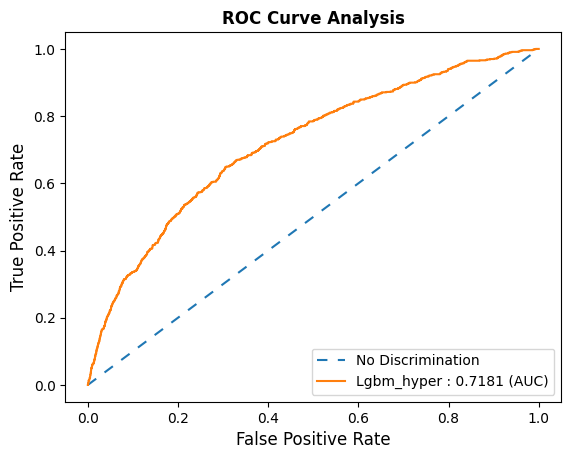

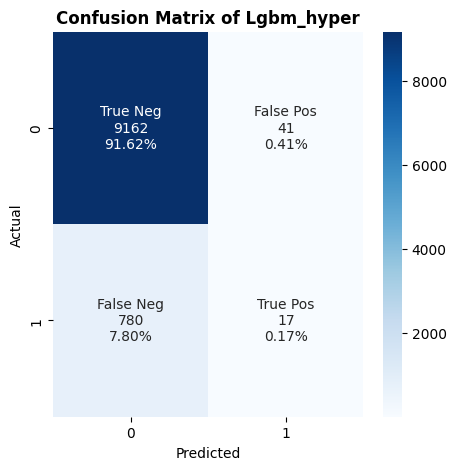

Evaluation_metrics on train data: {'auc': 0.89, 'accuracy': 0.93, 'precision': 0.88, 'recall': 0.1, 'F1_score': 0.17}
Evaluation_metrics on validation data: {'auc': 0.72, 'accuracy': 0.92, 'precision': 0.29, 'recall': 0.02, 'F1_score': 0.04}
Training Time: 9.02


In [62]:
param_LGBM = {'classifier__n_estimators': [10, 50, 100, 500],
        'classifier__max_depth': [3, 4, 5, 6],
        'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2],
        'classifier__subsample': [0.5, 0.7, 1.0],              
        'classifier__reg_lambda': [1e-3, 1e-2, 1e-1, 1, 2],
        'classifier__reg_alpha': [1e-3, 1e-2, 1e-1, 1, 2],
        'classifier__colsample_bytree': [0.95, 0.97, 0.99]}

splitter = StratifiedKFold(n_splits=3,shuffle=True,random_state=0)

start = time.time()
    
Lgbm_opt  = pipeline(LGBMClassifier())
    
cv_Lgbm_opt = RandomizedSearchCV(estimator=Lgbm_opt, param_distributions=param_LGBM, n_jobs= -1, 
                                  cv=splitter, verbose=0, n_iter = 100)  
    
cv_Lgbm_opt.fit(X_train, y_train)
    
# make predictions on the train dataset
y_pred_train = cv_Lgbm_opt.predict(X_train)
    
# predict roc_auc from probabilities and keep positive outcomes only
yprob_train = cv_Lgbm_opt.predict_proba(X_train)[:, 1]
    
# make predictions on the validation dataset
y_pred_val = cv_Lgbm_opt.predict(X_val)
    
# predict roc_auc from probabilities and keep positive outcomes only
yprob_val = cv_Lgbm_opt.predict_proba(X_val)[:, 1]
    
stop = time.time()
    
Training_Time = np.round((stop - start)/60, 2)
    
# performance metrics on training data
score_metrics_train = Evaluate_metrics(y_train, y_pred_train, yprob_train)
    
# performance metrics on validation data
score_metrics_val = Evaluate_metrics(y_val, y_pred_val, yprob_val)
    
# estimate the roc_auc score and confusion matrix on the validation data
ROC_AUC_Curve(y_val, yprob_val, "Lgbm_hyper")
cf_matrix_plot(y_val, y_pred_val, "Lgbm_hyper") 
    

# Start MLflow
with mlflow.start_run(run_name = "Lgbm_hyper"):
        
    # Track metrics
    for metric_val in score_metrics_val:
        mlflow.log_metric(metric_val, score_metrics_val[metric_val]) 
            
    mlflow.log_metric("Training_time", Training_Time)
        
    # track figures
    mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
    mlflow.log_artifact("roc_auc_curve.png", "roc_auc_curve")
            
    # logging the parameters        
    best_params = cv_Lgbm_opt.best_params_
    
    n_estimators = best_params['classifier__n_estimators']
    max_depth = best_params['classifier__max_depth']
    learning_rate = best_params['classifier__learning_rate']
    subsample = best_params['classifier__subsample']
    reg_lambda = best_params['classifier__reg_lambda']
    reg_alpha = best_params['classifier__reg_alpha']
    colsample_bytree = best_params['classifier__colsample_bytree']
    
    # Logging the model parameters used for this run.
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("subsample", subsample)
    mlflow.log_param("reg_lambda", reg_lambda)
    mlflow.log_param("reg_alpha", reg_alpha)
    mlflow.log_param("colsample_bytree", colsample_bytree) 
    
    # set tag   
    mlflow.set_tag("tag1", "Lgbm_hyper")

    # saving model with sklearn flavor (module)
    mlflow.sklearn.log_model(cv_Lgbm_opt, "Lgbm_hyper")

    print('Evaluation_metrics on train data:', score_metrics_train)
    print('Evaluation_metrics on validation data:', score_metrics_val)
    print('Training Time:', Training_Time)      

***Random Forest***

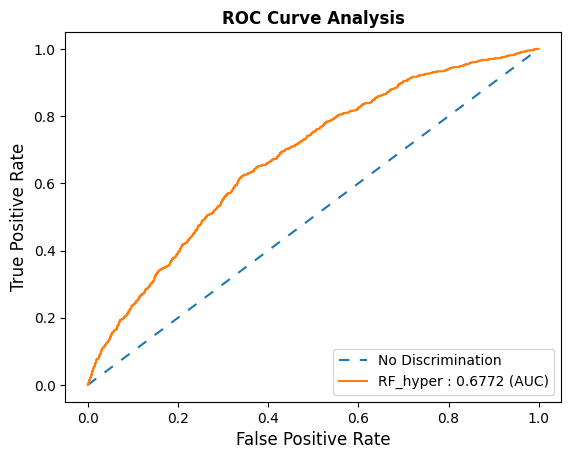

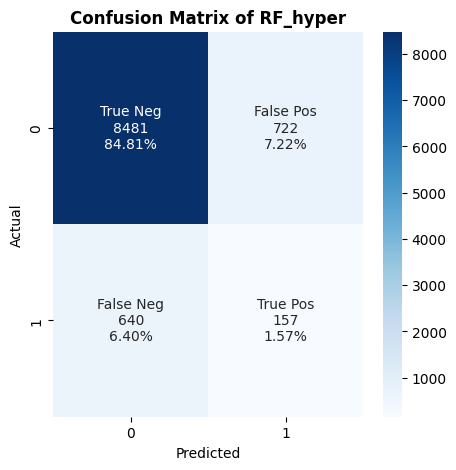

Evaluation_metrics on train data: {'auc': 0.89, 'accuracy': 0.9, 'precision': 0.38, 'recall': 0.43, 'F1_score': 0.4}
Evaluation_metrics on validation data: {'auc': 0.68, 'accuracy': 0.86, 'precision': 0.18, 'recall': 0.2, 'F1_score': 0.19}
Training Time: 14.17


In [63]:
param_RF = {'classifier__n_estimators': [10, 50, 100, 500],   
        'classifier__max_depth': [6, 8, 10, 12]}

RF = pipeline(RandomForestClassifier())

splitter = StratifiedKFold(n_splits=3,shuffle=True,random_state=0)

start = time.time()
    
cv_RF_opt = RandomizedSearchCV(estimator=RF, param_distributions=param_RF, n_jobs= -1, 
                                  cv=splitter, verbose=0, n_iter = 100)  
    
cv_RF_opt.fit(X_train, y_train)
    
# make predictions on the train dataset
y_pred_train = cv_RF_opt.predict(X_train)
    
# predict roc_auc from probabilities and keep positive outcomes only
yprob_train = cv_RF_opt.predict_proba(X_train)[:, 1]
    
# make predictions on the validation dataset
y_pred_val = cv_RF_opt.predict(X_val)
    
# predict roc_auc from probabilities and keep positive outcomes only
yprob_val = cv_RF_opt.predict_proba(X_val)[:, 1]
    
stop = time.time()
    
Training_Time = np.round((stop - start)/60, 2)
    
# performance metrics on training data
score_metrics_train = Evaluate_metrics(y_train, y_pred_train, yprob_train)
    
# performance metrics on validation data
score_metrics_val = Evaluate_metrics(y_val, y_pred_val, yprob_val)
    
# estimate the roc_auc score and confusion matrix on the validation data
ROC_AUC_Curve(y_val, yprob_val, "RF_hyper")
cf_matrix_plot(y_val, y_pred_val, "RF_hyper") 
    

# Start MLflow
with mlflow.start_run(run_name = "RF_hyper"):
        
    # Track metrics
    for metric_val in score_metrics_val:
        mlflow.log_metric(metric_val, score_metrics_val[metric_val]) 
            
    mlflow.log_metric("Training_time", Training_Time)
        
    # track figures
    mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
    mlflow.log_artifact("roc_auc_curve.png", "roc_auc_curve")
            
    # logging the parameters        
    best_params = cv_RF_opt.best_params_
    
    n_estimators = best_params['classifier__n_estimators']
    max_depth = best_params['classifier__max_depth']
        
    # Logging the model parameters used for this run.
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    
    # set tag   
    mlflow.set_tag("tag1", "RF_hyper")

    # saving model with sklearn flavor (module)
    mlflow.sklearn.log_model(cv_RF_opt, "RF_hyper")

    print('Evaluation_metrics on train data:', score_metrics_train)
    print('Evaluation_metrics on validation data:', score_metrics_val)
    print('Training Time:', Training_Time)      

***XGBoost***

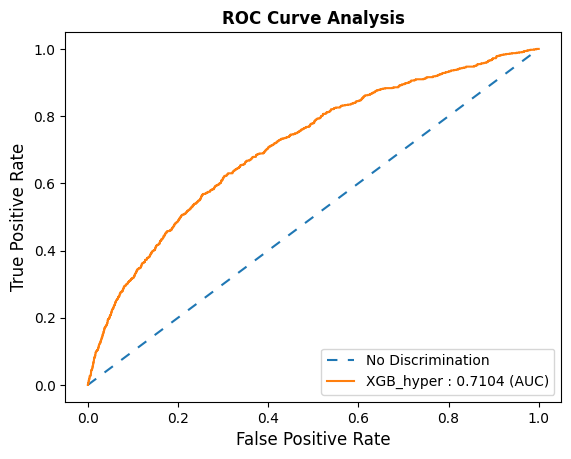

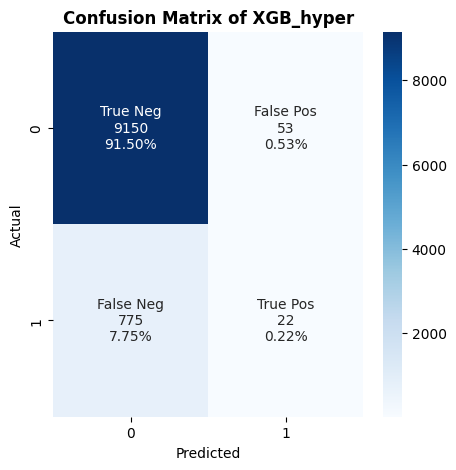

Evaluation_metrics on train data: {'auc': 0.99, 'accuracy': 0.96, 'precision': 0.99, 'recall': 0.48, 'F1_score': 0.64}
Evaluation_metrics on validation data: {'auc': 0.71, 'accuracy': 0.92, 'precision': 0.29, 'recall': 0.03, 'F1_score': 0.05}
Training Time: 272.54


In [113]:
mlflow.set_experiment('optimized_models_50N')

param_XGBoost = {'classifier__n_estimators': [1, 10, 100, 500], 
                 'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2],
                 'classifier__max_depth': [3, 4, 5, 6],
                 'classifier__subsample': [0.2, 0.5, 0.7, 1.0],
                 'classifier__colsample_bytree': [0.95, 0.97, 0.99],
                 'classifier__reg_lambda': [1e-3, 1e-2, 1e-1, 1, 2],
                 'classifier__reg_alpha': [1e-3, 1e-2, 1e-1, 1, 2]}

splitter = StratifiedKFold(n_splits=3,shuffle=True,random_state=0)

start = time.time()
    
XGB_opt  = pipeline(XGBClassifier())
    
cv_XGB_opt = RandomizedSearchCV(estimator=XGB_opt, param_distributions=param_XGBoost, n_jobs= -1, 
                                  cv=splitter, verbose=0, n_iter = 100)  
    
cv_XGB_opt.fit(X_train, y_train)
    
# make predictions on the train dataset
y_pred_train = cv_XGB_opt.predict(X_train)
    
# predict roc_auc from probabilities and keep positive outcomes only
yprob_train = cv_XGB_opt.predict_proba(X_train)[:, 1]
    
# make predictions on the validation dataset
y_pred_val = cv_XGB_opt.predict(X_val)
    
# predict roc_auc from probabilities and keep positive outcomes only
yprob_val = cv_XGB_opt.predict_proba(X_val)[:, 1]
    
stop = time.time()
    
Training_Time = np.round((stop - start)/60, 2)
    
# performance metrics on training data
score_metrics_train = Evaluate_metrics(y_train, y_pred_train, yprob_train)
    
# performance metrics on validation data
score_metrics_val = Evaluate_metrics(y_val, y_pred_val, yprob_val)
    
# estimate the roc_auc score and confusion matrix on the validation data
ROC_AUC_Curve(y_val, yprob_val, "XGB_hyper")
cf_matrix_plot(y_val, y_pred_val, "XGB_hyper") 
    

# Start MLflow
with mlflow.start_run(run_name = "XGB_hyper"):
        
    # Track metrics
    for metric_val in score_metrics_val:
        mlflow.log_metric(metric_val, score_metrics_val[metric_val]) 
            
    mlflow.log_metric("Training_time", Training_Time)
        
    # track figures
    mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
    mlflow.log_artifact("roc_auc_curve.png", "roc_auc_curve")
            
    # logging the parameters        
    best_params = cv_XGB_opt.best_params_
    
    n_estimators = best_params['classifier__n_estimators']
    max_depth = best_params['classifier__max_depth']
    learning_rate = best_params['classifier__learning_rate']
    subsample = best_params['classifier__subsample']
    reg_lambda = best_params['classifier__reg_lambda']
    reg_alpha = best_params['classifier__reg_alpha']
    colsample_bytree = best_params['classifier__colsample_bytree']
    
    
    # Logging the model parameters used for this run.
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("subsample", subsample)
    mlflow.log_param("reg_lambda", reg_lambda)
    mlflow.log_param("reg_alpha", reg_alpha)
    mlflow.log_param("colsample_bytree", colsample_bytree)
    
    # set tag   
    mlflow.set_tag("tag1", "XGB_hyper")

    # saving model with sklearn flavor (module)
    mlflow.sklearn.log_model(cv_XGB_opt, "XGB_hyper")

    print('Evaluation_metrics on train data:', score_metrics_train)
    print('Evaluation_metrics on validation data:', score_metrics_val)
    print('Training Time:', Training_Time)  

### 6.2.4 Threshold optimization and custom score

Business context:
- The aim is to build a model that can predict a class’s probability and a decision threshold to separate the target classes - good and bad customers.

- The "business" problem is to take into account that a false positive (good customer considered as bad = credit not granted wrongly, therefore loss of margin for the bank) does not have the same cost as a false negative (bad customer to whom a loan is granted, therefore loss on the unpaid capital). A false negative is about 10 times more expensive than a false positive. Technical measures such as the f1 score and accuracy do not take this into account. 


- A new business score (custom_score), which calculates the cost of prediction errors, is created by "make_scorer" and declared as the scoring parameter during tuning by RandomSearchCV. The custom_score is calculated based on the business objective as 10FN (false negative) + FP (False positive). Thus, the goal is to increase the weight of FN by 10 (10 * fn), which should reduce the false negative. The best model is evaluated as the one with the best average business score (custom_score) and find it's optimum threshold.  

- A classifier typically uses a default classification threshold of 0.5 to classify the positive and negative classes. However, since we have an imbalance class, the default 0.5 threshold results in poor performance. Adjusting the decision threshold is therefore necessary to improve the performance of the model and minimize the number of classification errors (Type I and Type II).

In [64]:
mlflow.set_experiment('Tuned_models_50N')

2023/02/21 08:26:59 INFO mlflow.tracking.fluent: Experiment with name 'Tuned_models_50N' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/756396904473645102', creation_time=1676964419329, experiment_id='756396904473645102', last_update_time=1676964419329, lifecycle_stage='active', name='Tuned_models_50N', tags={}>

In [65]:
def metrics_eva(y_test, yprob, y_proba):
    acc = accuracy_score(y_test, y_proba)
    prec = precision_score(y_test, y_proba)
    recall = recall_score(y_test, y_proba)
    F1_score = f1_score(y_test, y_proba)
    auc = roc_auc_score(y_test, yprob)
    custom_score = My_scorer(y_test, y_proba)
    return {'custom_score': round(custom_score, 2), 'auc': round(auc, 2), 'accuracy': round(acc, 2), 
            'precision': round(prec, 2), 'recall': round(recall, 2), 'F1_score': round(F1_score, 2)}

In [66]:
# create a custom_score
def My_scorer(y_test, y_pred):
    """Function that extracts from the confusion matrix the values of the 4 measures and 
    returns a calculation based on a weighting of FP and FN"""
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (10*fn + fp)/len(y_test)

***LGBM***

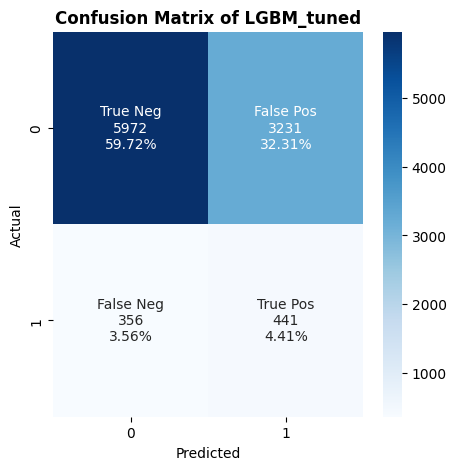

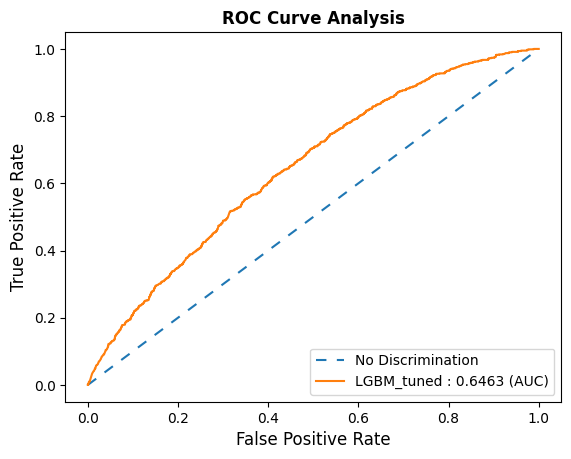

Best_custom_score:  -0.689
Evaluation_metrics on validation data: {'custom_score': 0.68, 'auc': 0.65, 'accuracy': 0.64, 'precision': 0.12, 'recall': 0.55, 'F1_score': 0.2}
Optimal_class_threhold: 0.4040404040404041
Training Time: 17.42


In [69]:
# create a custom score
scorer = make_scorer(My_scorer, greater_is_better=False)

# define cross-validation parameters
splitter = StratifiedKFold(n_splits=3,shuffle=True,random_state=0)

param_LGBM = {'classifier__n_estimators': [10, 50, 100, 500],
        'classifier__max_depth': [3, 4, 5, 6],
        'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2],
        'classifier__subsample': [0.5, 0.7, 1.0],              
        'classifier__reg_lambda': [1e-3, 1e-2, 1e-1, 1, 2],
        'classifier__reg_alpha': [1e-3, 1e-2, 1e-1, 1, 2],
        'classifier__colsample_bytree': [0.95, 0.97, 0.99]}

start = time.time()
    
LGBM_model = pipeline(LGBMClassifier())
    
LGBM_cv = RandomizedSearchCV(estimator=LGBM_model, param_distributions=param_LGBM, n_jobs= -1, cv=splitter, 
                                    scoring = scorer, verbose=0, n_iter = 100)  
    
LGBM_cv.fit(X_train, y_train)
    
# make predictions on the train dataset
y_pred_train = LGBM_cv.predict(X_train)
    
# predict roc_auc from probabilities and keep positive outcomes only
yprob_train = LGBM_cv.predict_proba(X_train)[:, 1]
    
# make predictions on the validation dataset
y_pred_val = LGBM_cv.predict(X_val)
   
# predict roc_auc from probabilities and keep positive outcomes only
yprob_val = LGBM_cv.predict_proba(X_val)[:, 1]
    
stop = time.time()
    
# Create a range of equally spaced threshold values
t_range = np.linspace(0,1,100) 
    
# get optimal tpr-fpr threshold
t_opt = None
best_score = 1
    
for t in t_range:
    custom_score = My_scorer(y_val, yprob_val>t)
        
    if custom_score < best_score:
        t_opt = t
        best_score = custom_score    
    
y_proba_val = yprob_val > t_opt # positive if > thresh (1) and negative if lower (0)
    
score_metrics_val = metrics_eva(y_val, yprob_val, y_proba_val)
    
Training_Time = np.round((stop - start)/60, 2)
    
# confusion matrix    
cf_matrix_plot(y_val, y_proba_val, "LGBM_tuned")
ROC_AUC_Curve(y_val, yprob_val, "LGBM_tuned")
    
# Start MLflow
with mlflow.start_run(run_name = "LGBM_tuned"):
    
    for metric_val in score_metrics_val:
        mlflow.log_metric(metric_val, score_metrics_val[metric_val]) 
            
    mlflow.log_metric("Thres_opt", t_opt)
    mlflow.log_metric("Training_time", Training_Time)
        
    # track figures
    mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
    mlflow.log_artifact("roc_auc_curve.png", "roc_auc_curve")
            
    # logging the parameters        
    best_params = LGBM_cv.best_params_
    
    n_estimators = best_params['classifier__n_estimators']
    max_depth = best_params['classifier__max_depth']
    learning_rate = best_params['classifier__learning_rate']
    subsample = best_params['classifier__subsample']
    reg_lambda = best_params['classifier__reg_lambda']
    reg_alpha = best_params['classifier__reg_alpha']
    colsample_bytree = best_params['classifier__colsample_bytree']
    
    # Logging the model parameters used for this run.
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("subsample", subsample)
    mlflow.log_param("reg_lambda", reg_lambda)
    mlflow.log_param("reg_alpha", reg_alpha)
    mlflow.log_param("colsample_bytree", colsample_bytree)
    
    # set tag   
    mlflow.set_tag("tag1", "LGBM_tuned")
   
    # saving model with sklearn flavor (module)
    mlflow.sklearn.log_model(LGBM_cv, "LGBM_tuned")
    mlflow.end_run()

    print("Best_custom_score: ", round(LGBM_cv.best_score_, 3))
    print('Evaluation_metrics on validation data:', score_metrics_val)
    print('Optimal_class_threhold:', t_opt)
    print('Training Time:', Training_Time)      

***Logistic Regression***

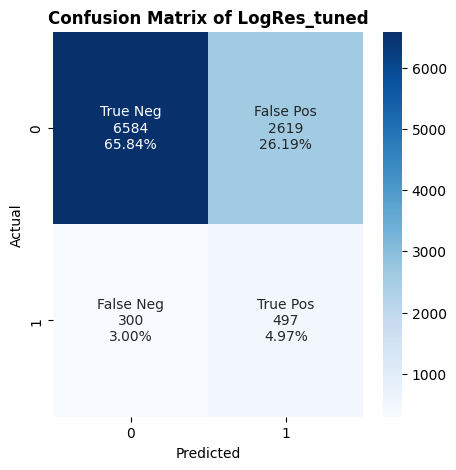

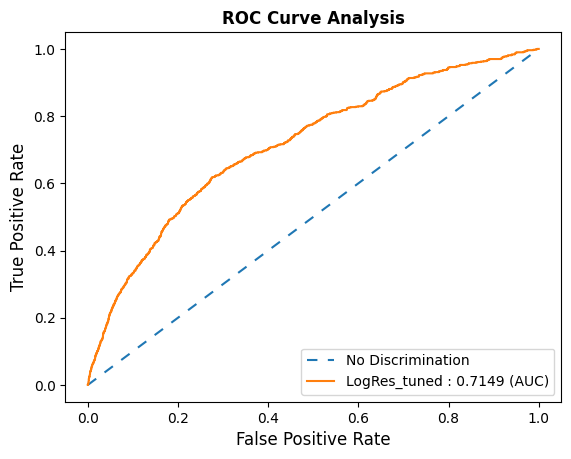

Best_custom_score:  -0.569
Evaluation_metrics on validation data: {'custom_score': 0.56, 'auc': 0.71, 'accuracy': 0.71, 'precision': 0.16, 'recall': 0.62, 'F1_score': 0.25}
Optimal_class_threhold: 0.5151515151515152
Training Time: 11.86


In [70]:
param_LR = {'classifier__penalty': ['l1','l2'],   
           'classifier__C': [0.25, 0.5, 0.75, 1],
           'classifier__max_iter': [10, 50, 100, 500]}
start = time.time()
    
LogRes_model = pipeline(LogisticRegression())
    
LogRes_cv = RandomizedSearchCV(estimator=LogRes_model, param_distributions=param_LR, n_jobs= -1, cv=splitter, 
                                    scoring = scorer, verbose=0, n_iter = 100)  
    
LogRes_cv.fit(X_train, y_train)
    
# make predictions on the train dataset
y_pred_train = LogRes_cv.predict(X_train)
    
# predict roc_auc from probabilities and keep positive outcomes only
yprob_train = LogRes_cv.predict_proba(X_train)[:, 1]
    
# make predictions on the validation dataset
y_pred_val = LogRes_cv.predict(X_val)
   
# predict roc_auc from probabilities and keep positive outcomes only
yprob_val = LogRes_cv.predict_proba(X_val)[:, 1]
    
stop = time.time()
    
# Create a range of equally spaced threshold values
t_range = np.linspace(0,1,100) 
    
# get optimal tpr-fpr threshold
t_opt = None
best_score = 1
    
for t in t_range:
    custom_score = My_scorer(y_val, yprob_val>t)
        
    if custom_score < best_score:
        t_opt = t
        best_score = custom_score    
    
y_proba_val = yprob_val > t_opt # positive if > thresh (1) and negative if lower (0)
    
score_metrics_val = metrics_eva(y_val, yprob_val, y_proba_val)
    
Training_Time = np.round((stop - start)/60, 2)
    
# confusion matrix and roc_auc curve   
cf_matrix_plot(y_val, y_proba_val, "LogRes_tuned")
ROC_AUC_Curve(y_val, yprob_val, "LogRes_tuned")
    
# Start MLflow
with mlflow.start_run(run_name = "LogRes_tuned"):
        
    # Track metrics
    for metric_val in score_metrics_val:
        mlflow.log_metric(metric_val, score_metrics_val[metric_val]) 
            
    mlflow.log_metric("Thres_opt", t_opt)
    mlflow.log_metric("Training_time", Training_Time)
        
    # track figures
    mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
    mlflow.log_artifact("roc_auc_curve.png", "roc_auc_curve")
            
    # logging the parameters        
    best_params = LogRes_cv.best_params_
    
    penalty = best_params['classifier__penalty']
    C = best_params['classifier__C']
    max_iter = best_params['classifier__max_iter']
        
    # Logging the model parameters used for this run.
    mlflow.log_param("penalty", penalty)
    mlflow.log_param("C", C)
    mlflow.log_param("max_iter", max_iter)
    
    # set tag   
    mlflow.set_tag("tag1", "LogRes_tuned")
   
    # saving model with sklearn flavor (module)
    mlflow.sklearn.log_model(LogRes_cv, "LogRes_tuned")
    
    print("Best_custom_score: ", round(LogRes_cv.best_score_, 3))
    print('Evaluation_metrics on validation data:', score_metrics_val)
    print('Optimal_class_threhold:', t_opt)
    print('Training Time:', Training_Time)      
    mlflow.end_run()

***Random Forest***

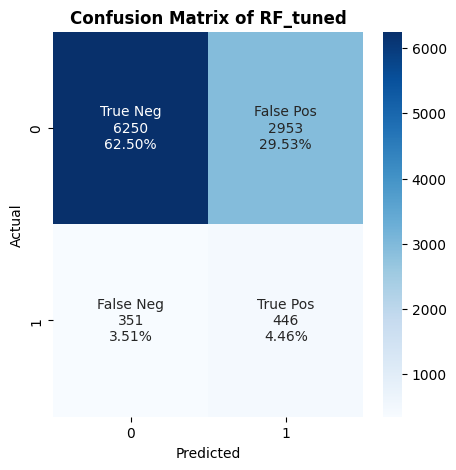

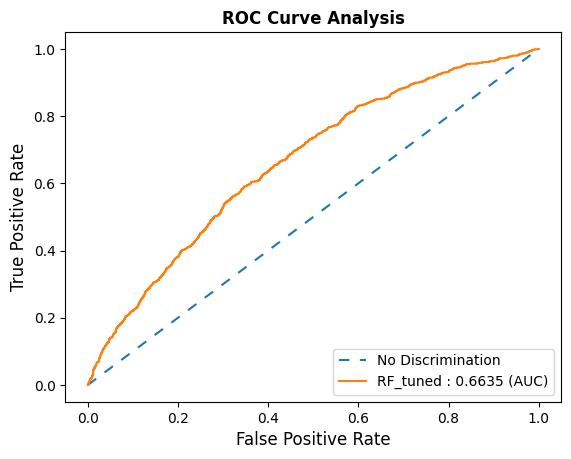

Best_custom_score:  -0.666
Evaluation_metrics on validation data: {'custom_score': 0.65, 'auc': 0.66, 'accuracy': 0.67, 'precision': 0.13, 'recall': 0.56, 'F1_score': 0.21}
Optimal_class_threhold: 0.43434343434343436
Training Time: 18.4


In [71]:
param_RF = {'classifier__n_estimators': [10, 50, 100, 500],   
        'classifier__max_depth': [6, 8, 10, 12]}

start = time.time()
    
RF_model = pipeline(RandomForestClassifier())
    
RF_cv = RandomizedSearchCV(estimator=RF_model, param_distributions=param_RF, n_jobs= -1, cv=splitter, 
                                    scoring = scorer, verbose=0, n_iter = 100)  
    
RF_cv.fit(X_train, y_train)
    
# make predictions on the train dataset
y_pred_train = RF_cv.predict(X_train)
    
# predict roc_auc from probabilities and keep positive outcomes only
yprob_train = RF_cv.predict_proba(X_train)[:, 1]
    
# make predictions on the validation dataset
y_pred_val = RF_cv.predict(X_val)
   
# predict roc_auc from probabilities and keep positive outcomes only
yprob_val = RF_cv.predict_proba(X_val)[:, 1]
    
stop = time.time()
    
# Create a range of equally spaced threshold values
t_range = np.linspace(0,1,100) 
    
# get optimal tpr-fpr threshold
t_opt = None
best_score = 1
    
for t in t_range:
    custom_score = My_scorer(y_val, yprob_val>t)
        
    if custom_score < best_score:
        t_opt = t
        best_score = custom_score    
    
y_proba_val = yprob_val > t_opt # positive if > thresh (1) and negative if lower (0)
    
score_metrics_val = metrics_eva(y_val, yprob_val, y_proba_val)
    
Training_Time = np.round((stop - start)/60, 2)
    
# confusion matrix    
cf_matrix_plot(y_val, y_proba_val, "RF_tuned")
ROC_AUC_Curve(y_val, yprob_val, "RF_tuned")
    
# Start MLflow
with mlflow.start_run(run_name = "RF_tuned"):
        
    # Track metrics
    for metric_val in score_metrics_val:
        mlflow.log_metric(metric_val, score_metrics_val[metric_val]) 
            
    mlflow.log_metric("Thres_opt", t_opt)
    mlflow.log_metric("Training_time", Training_Time)
        
    # track figures
    mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
    mlflow.log_artifact("roc_auc_curve.png", "roc_auc_curve")
            
    # logging the parameters        
    best_params = RF_cv.best_params_
    
    n_estimators = best_params['classifier__n_estimators']
    max_depth = best_params['classifier__max_depth']
        
    # Logging the model parameters used for this run.
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    
    # set tag   
    mlflow.set_tag("tag1", "RF_tuned")
   
    # saving model with sklearn flavor (module)
    mlflow.sklearn.log_model(RF_cv, "RF_tuned")
    
    print("Best_custom_score: ", round(RF_cv.best_score_, 3))
    print('Evaluation_metrics on validation data:', score_metrics_val)
    print('Optimal_class_threhold:', t_opt)
    print('Training Time:', Training_Time)      
    mlflow.end_run()

***XGBoost***

2023/02/21 10:25:54 INFO mlflow.tracking.fluent: Experiment with name 'Tuned_models_50Nk' does not exist. Creating a new experiment.


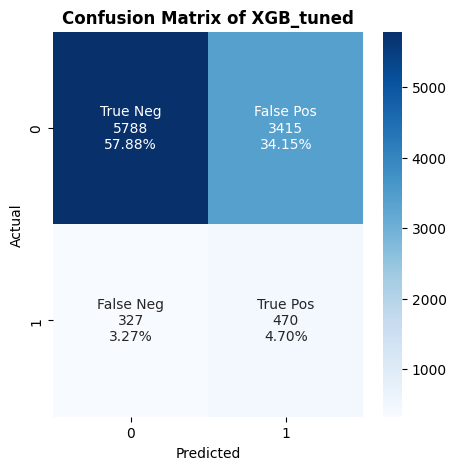

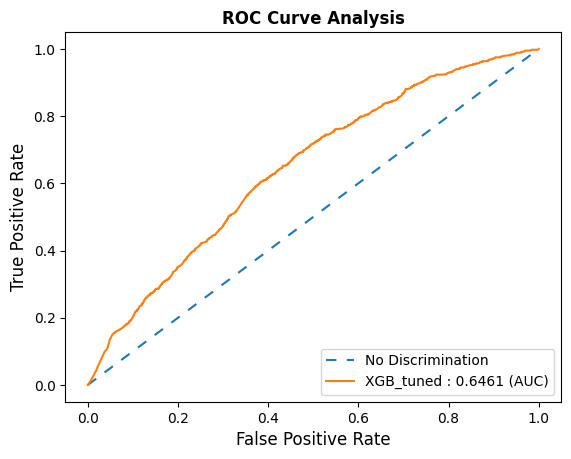

Best_custom_score:  -0.684
Evaluation_metrics on validation data: {'custom_score': 0.67, 'auc': 0.65, 'accuracy': 0.63, 'precision': 0.12, 'recall': 0.59, 'F1_score': 0.2}
Optimal_class_threhold: 0.4444444444444445
Training Time: 211.22


In [111]:
param_XGBoost = {'classifier__n_estimators': [1, 10, 100, 500], 
                 'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2],
                 'classifier__max_depth': [3, 4, 5, 6],
                 'classifier__subsample': [0.2, 0.5, 0.7, 1.0],
                 'classifier__colsample_bytree': [0.95, 0.97, 0.99],
                 'classifier__reg_lambda': [1e-3, 1e-2, 1e-1, 1, 2],
                 'classifier__reg_alpha': [1e-3, 1e-2, 1e-1, 1, 2]}

start = time.time()
    
XGB_model = pipeline(XGBClassifier())
    
XGB_cv = RandomizedSearchCV(estimator=XGB_model, param_distributions=param_XGBoost, n_jobs= -1, cv=splitter, 
                                    scoring = scorer, verbose=0, n_iter = 100)  
    
XGB_cv.fit(X_train, y_train)
    
# make predictions on the train dataset
y_pred_train = XGB_cv.predict(X_train)
    
# predict roc_auc from probabilities and keep positive outcomes only
yprob_train = XGB_cv.predict_proba(X_train)[:, 1]
    
# make predictions on the validation dataset
y_pred_val = XGB_cv.predict(X_val)
   
# predict roc_auc from probabilities and keep positive outcomes only
yprob_val = XGB_cv.predict_proba(X_val)[:, 1]
    
stop = time.time()
    
# Create a range of equally spaced threshold values
t_range = np.linspace(0,1,100) 
    
# get optimal tpr-fpr threshold
t_opt = None
best_score = 1
    
for t in t_range:
    custom_score = My_scorer(y_val, yprob_val>t)
        
    if custom_score < best_score:
        t_opt = t
        best_score = custom_score    
    
y_proba_val = yprob_val > t_opt # positive if > thresh (1) and negative if lower (0)
    
score_metrics_val = metrics_eva(y_val, yprob_val, y_proba_val)
    
Training_Time = np.round((stop - start)/60, 2)
    
# confusion matrix    
cf_matrix_plot(y_val, y_proba_val, "XGB_tuned")
ROC_AUC_Curve(y_val, yprob_val, "XGB_tuned")
    
# Start MLflow
with mlflow.start_run(run_name = "XGB_tuned"):
        
    # Track metrics
    for metric_val in score_metrics_val:
        mlflow.log_metric(metric_val, score_metrics_val[metric_val]) 
            
    mlflow.log_metric("Thres_opt", t_opt)
    mlflow.log_metric("Training_time", Training_Time)
        
    # track figures
    mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
    mlflow.log_artifact("roc_auc_curve.png", "roc_auc_curve")
            
    # logging the parameters        
    best_params = XGB_cv.best_params_
    
    n_estimators = best_params['classifier__n_estimators']
    max_depth = best_params['classifier__max_depth']
    learning_rate = best_params['classifier__learning_rate']
    subsample = best_params['classifier__subsample']
    reg_lambda = best_params['classifier__reg_lambda']
    reg_alpha = best_params['classifier__reg_alpha']
    colsample_bytree = best_params['classifier__colsample_bytree']
    
    
    # Logging the model parameters used for this run.
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("subsample", subsample)
    mlflow.log_param("reg_lambda", reg_lambda)
    mlflow.log_param("reg_alpha", reg_alpha)
    mlflow.log_param("colsample_bytree", colsample_bytree)
    
    # set tag   
    mlflow.set_tag("tag1", "XGB_tuned")
   
    # saving model with sklearn flavor (module)
    mlflow.sklearn.log_model(XGB_cv, "XGB_tuned")
    mlflow.end_run()

    print("Best_custom_score: ", round(XGB_cv.best_score_, 3))
    print('Evaluation_metrics on validation data:', score_metrics_val)
    print('Optimal_class_threhold:', t_opt)
    print('Training Time:', Training_Time)  

***Best custom score***: * LGBM has the highest custom score of 0.69, followed by XGBoost with 0.68, while logistic regression has the least custome score of ~0.57 after optimization of threshold and implementation of the business requirement. Therefore, **LGBM** is selected as the best model because of it's high custom scores and AUC score. It also has a fast and low training time compared to it's closest rival - XGBoost.

### 6.2.5 Best model

Owing to the objective of this project, the best model is chosen based on the combined AUC scores and custom scores after hyperparameter and threshold tuning, respectively. In addition to the custom score, the best model and training must also have a high recall since the business goal is to decrease the number of customers classified as FN (false negatives). Therefore, after several runs and tracking by mlflow, LGBM has the highest highest custom and AUC scores after threshold tuning and hyperparameter optimization, and the best selected LGBM run in Mlflow is the one with the highest recall. 

In [57]:
# Load the best model
run_id =  "0975c0cf3eab428db919bbd2fcc34c58"
model_name = "LGBM_tuned"
LGBM_Best_model = mlflow.sklearn.load_model(f"runs:/{run_id}/{model_name}")

In [92]:
Tuned_LGBM = LGBM_Best_model.best_estimator_
Tuned_LGBM

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'FLAG_MOBIL',
                                                   'FLAG_EMP_PHONE',
                                                   'FLAG_WORK_PHONE',
                                                   'FLAG_CONT_MOBILE',
                                                   'FLAG_PHON...
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'ORGANIZATION_TYPE',
                                                   'FONDKAPREMONT_MODE',
                                                   'HOUSETYPE_MODE',
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE'])])),
                ('smote', SMOTE()),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.99, learning_rate=0.001,
                                max_depth=5, n_estimators=500, reg_alpha=0.01,
                                reg_lambda=0.01))])

In [59]:
# save the best model
pickle.dump(Tuned_LGBM, open("Tuned_LGBM_50N.p", "wb"))

In [60]:
# save the optimal class threshold
Thres_opt = 0.424
pickle.dump(Thres_opt, open("Thres_opt.p_50N", "wb"))

### 6.2.6 Predictions

#### a. predictions on the cleaned application_test dataset

In [61]:
Test_clean = pickle.load(open("Test_clean_50N.p", "rb"))

In [62]:
# import the clean text data
Text_pred = Test_clean.drop('SK_ID_CURR', axis = 1)

# predict_model
ypreds = Tuned_LGBM.predict(Text_pred )

# get the probability value and 
yproba_opt = Tuned_LGBM.predict_proba(Text_pred)[:, 1]

Since yproba_opt returns a probability value and not the class label, we set a decision threshold (Thres_opt) to label the outcome - if predict_proba is less than threshold, it returns 0 (non-defaulter), else 1 (loan defaulter)

In [63]:
# get the predictions
predict_proba = yproba_opt >= Thres_opt 

# get the class label
y_predict = np.array(predict_proba > 0) * 1

In [64]:
# Get the test data

# append id to test_data
Text_pred['SK_ID_CURR'] = Test_clean['SK_ID_CURR']
Text_pred['PROBABILITY'] = yproba_opt
Text_pred['PREDICTION'] = y_predict
Text_df_Target = Text_pred.set_index('SK_ID_CURR')
Text_df_Target.reset_index(inplace = True)

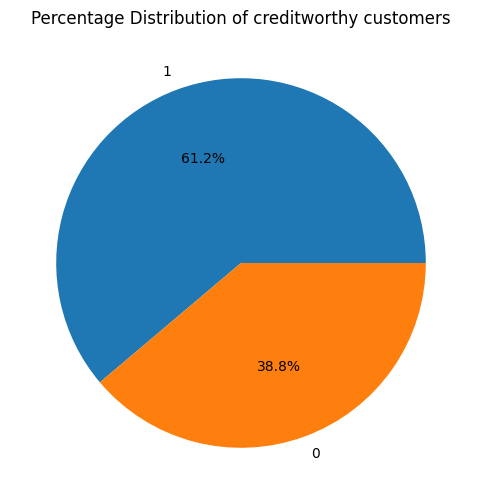

In [65]:
#Distribution of the clients predictions in the test data

label = [1, 0] #Text_df_Target["PREDICTION"].unique()
plt.figure(figsize=(6,6))
plt.pie(Text_df_Target["PREDICTION"].value_counts(), labels=label, autopct='%1.1f%%', radius=1)
plt.title("Percentage Distribution of creditworthy customers")
plt.show()

## 7.0 Feature importance

### Interpreting model with SHAP (SHapley Additive exPlanations)
 - to understand what input features drive the prediction result
 - done using the back-up 10,000 observations of the X_test data split from the training data set

In [66]:
#load JS vis in the notebook
shap.initjs()

In [67]:
# Declare model
# get list of features from tranformed data
feature_names = Tuned_LGBM.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(Cat_features)
all_cols = np.concatenate([Num_features, feature_names])

In [68]:
# save the shal_columns
pickle.dump(all_cols, open("all_columns_50N.p", "wb"))

In [69]:
# Display the test_dataset for SHAP, API and deployment
X_shap = pickle.load(open("Test_clean_50N.p", "rb"))

In [70]:
# create dataframe for the input sample
X_encode = Tuned_LGBM['preprocessor'].transform(X_shap)
X_encode_df = pd.DataFrame(data = X_encode, columns = all_cols)

In [71]:
# Initialize explainer
explainer = shap.TreeExplainer(Tuned_LGBM['classifier'])
shap_values = explainer.shap_values(X_encode_df, check_additivity=False) # all predictions

- The shap_values (explainer.shap_values() method) variable represents all the negative and positive predictions. The shap_values object is a list with two arrays. The first array is the SHAP values for a negative outcome (customer will not default), and the second array is the list of SHAP values for the positive outcome (customer will default).

### 7.1 Global feature importance (explainability)

**7.1.1 Summary plot for a global graphic interpretation**

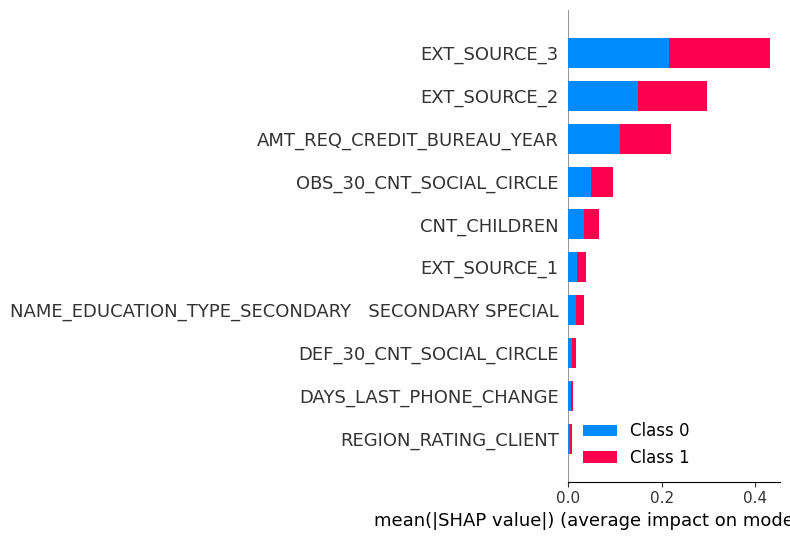

In [72]:
shap.summary_plot(shap_values, X_encode_df, plot_type="bar", max_display=10)

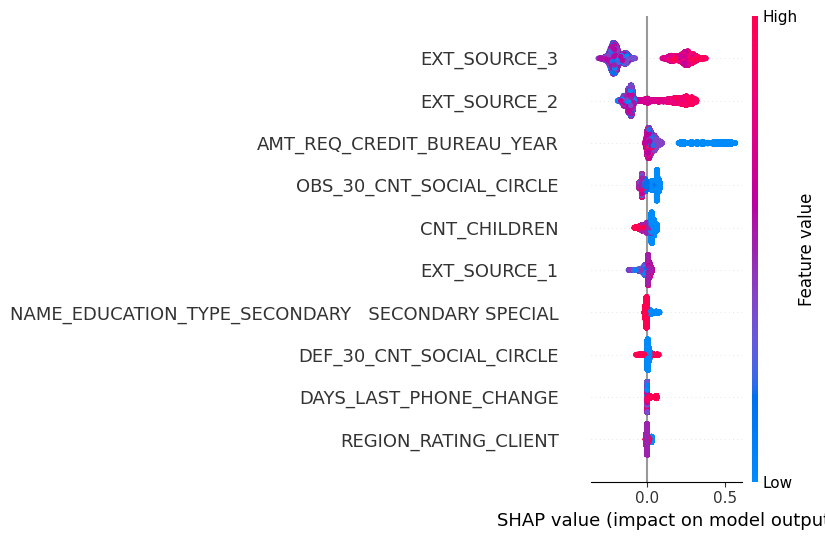

In [73]:
shap.summary_plot(shap_values[0], X_encode_df, max_display=10)

#### Shap values - classification

- Since the interest on most predictions typically focuses more on predicting the positive outcome, so I'll also pull extract the SHAP values for positive outcomes (loan defaulters - shap_values_p[1]).

In [74]:
explainer_1 = shap.TreeExplainer(Tuned_LGBM['classifier'], X_encode_df)
shap_values_1 = explainer_1(X_encode_df, check_additivity=False)

100%|===================| 48704/48744 [12:19<00:00]        

- The shap_values_1, created using explainer()command has three attributes: .data, .base_values and .values.

    - .data: value for each input feature
    - .base_values: probability of each target class
    - .values: SHAP value for each feature.
    
- Since the interest on most predictions typically focuses more on predicting the positive outcome. I'll focus on the SHAP values for the positive (loan defaulters - shap_values_p[1]) class.

#### 7.1.2 Summary Plot
 - strength of individual features

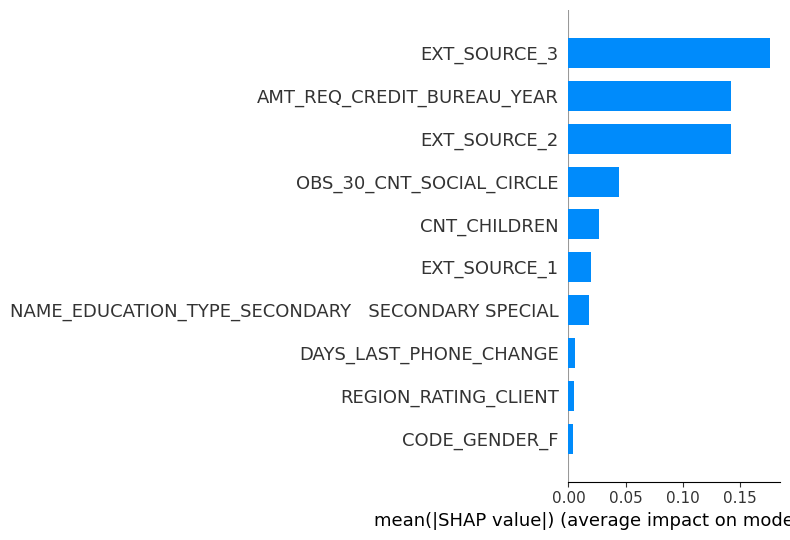

In [75]:
shap.summary_plot(shap_values_1, X_encode_df, plot_type="bar", max_display=10)

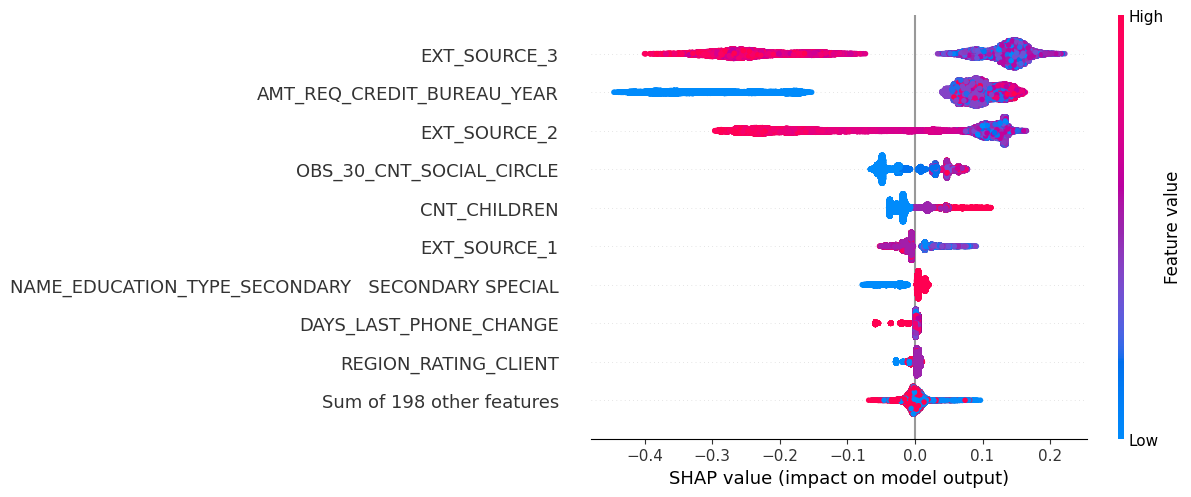

In [76]:
shap.plots.beeswarm(shap_values_1)

#### 7.1.3 Feature importance values

In [77]:
# compute mean of absolute values for shap values
shap_values_2 = explainer_1.shap_values(X_encode_df, check_additivity = False)
ab_values = np.abs(shap_values_2).mean(0)

# compute feature importance as a dataframe containing vals
feature_importance = pd.DataFrame(list(zip(all_cols, ab_values)),\
                                  columns=['col_name','feature_importance_vals'])

# display top 15 feature importance sorted
feature_importance.sort_values(by='feature_importance_vals', ascending=False)[0:20]

100%|===================| 48718/48744 [12:34<00:00]        

,col_name,feature_importance_vals
23,EXT_SOURCE_3,0.175966
59,AMT_REQ_CREDIT_BUREAU_YEAR,0.142108
22,EXT_SOURCE_2,0.141533
31,OBS_30_CNT_SOCIAL_CIRCLE,0.043968
0,CNT_CHILDREN,0.026320
21,EXT_SOURCE_1,0.019337
90,NAME_EDUCATION_TYPE_SECONDARY SECONDARY SPECIAL,0.017591
33,DAYS_LAST_PHONE_CHANGE,0.005517
15,REGION_RATING_CLIENT,0.005242
64,CODE_GENDER_F,0.003870


### 7.2 Local interpretability
 - understanding predictions of individual cases

#### 7.2.1 Bar plots

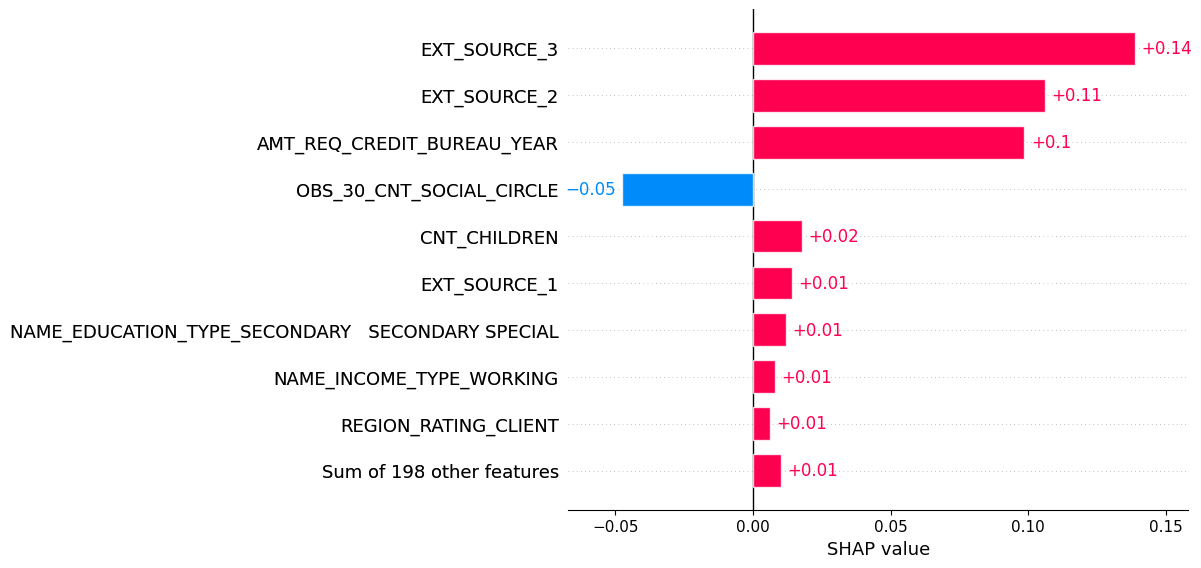

In [78]:
shap.plots.bar(shap_values_1[4])

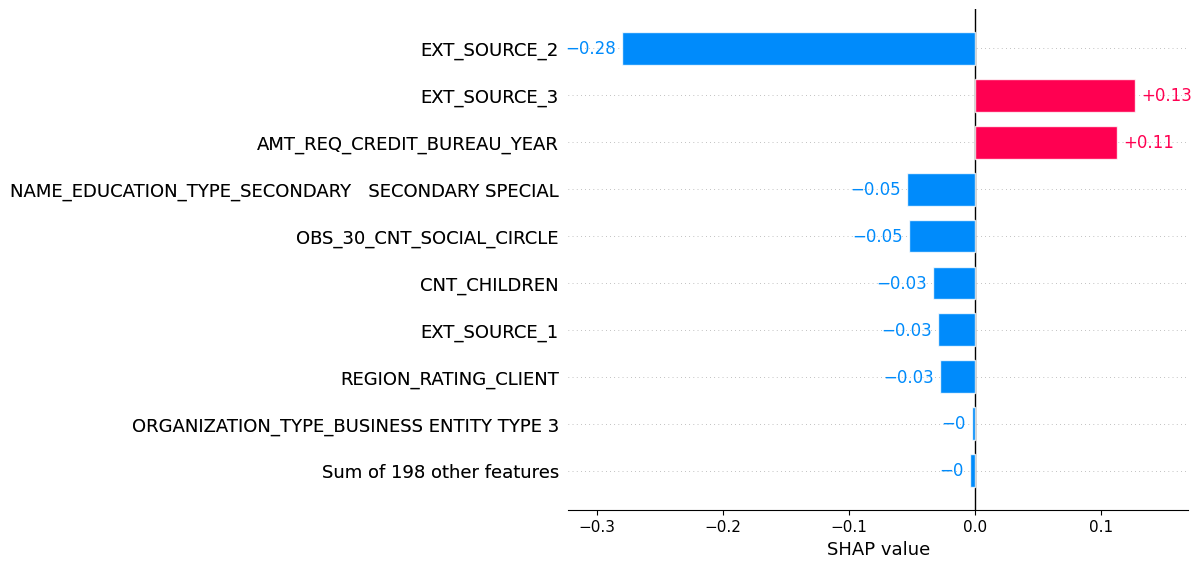

In [79]:
shap.plots.bar(shap_values_1[8])

**7.2.2 Force plots**

In [80]:
# Plot for positive sample
shap.force_plot(explainer.expected_value[0], shap_values[0][1,:], X_encode_df.iloc[1,:])

In [81]:
# Plot for negative sample
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_encode_df.iloc[0,:])

In [82]:
shap.force_plot(shap_values_1.base_values[1], shap_values_1.values[0],\
                feature_names=shap_values_1.feature_names)

**Summary:** EXT_SOURCE_3, EXT_SOURCE_2, AMT_REQ_CREDIT_BUREAU_YEAR, OBS_30_CNT_SOCIAL_CIRCLE, and CNT_CHILDREN are the top 5 features with the biggest contribution among the 78 features that are used.

### 8.0 Data Drift Analysis - Evidently

### 8.1.  Prepare datasets
- use the clean application dataset as reference data and the cleaned test dataset with predicted target as current dataset

In [83]:
# Create list of top 15 feature importance from Shap + the target
selected_cols = columns_import = ['TARGET', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'FLAG_WORK_PHONE',
                                  'CNT_CHILDREN','NAME_EDUCATION_TYPE', 'EXT_SOURCE_1', 'DEF_30_CNT_SOCIAL_CIRCLE', 
                                  'OBS_30_CNT_SOCIAL_CIRCLE', 'REGION_RATING_CLIENT', 'AMT_REQ_CREDIT_BUREAU_MON', 
                                  'CODE_GENDER', 'PAYMENT_RATE', 'OCCUPATION_TYPE', 'DAYS_LAST_PHONE_CHANGE']

In [84]:
# Get the reference dataset from the train_clean dataset
Data_reference = Train_clean.copy()
Data_reference = Data_reference[selected_cols]

# Get the current dataset
# production dataset from prediction as current dataset from Test-clean dataset after prediction
Text_df_Target['TARGET'] = Text_df_Target['PREDICTION'] 
Data_current = Text_df_Target[selected_cols]

### 8.2. Data Drift Dashboard without column mapping
- Data drift report

In [85]:
DataEvi_Drift_Dashboard = Dashboard(tabs = [DataDriftTab()])
DataEvi_Drift_Dashboard.calculate(Data_reference, Data_current, column_mapping = None)

Displaying drift inline

In [86]:
DataEvi_Drift_Dashboard.show(mode='inline')

# Save the data
DataEvi_Drift_Dashboard.save('DataEvi_Drift_Dashboard_50N.html')

**Note**
- Drift is detected for 37.50% of features (6 out of 16). These features are PAYMENT_RATE, TARGET, AMT_REQ_CREDIT_BUREAU_MON, EXT_SOURCE_1, DAYS_LAST_PHONE_CHANGE, and AMT_REQ_CREDIT_BUREAU_YEAR.

### 8.3. Target Drift Dashboard With column mapping
 - Target_drift_report

In [87]:
target_column_mapping = ColumnMapping()
target_column_mapping.target = 'TARGET'

target_column_mapping.numerical_feat = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_YEAR',
                                        'CNT_CHILDREN','EXT_SOURCE_1', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE',
                                        'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT', 'PAYMENT_RATE',
                                        'AMT_REQ_CREDIT_BUREAU_MON' , 'DAYS_LAST_PHONE_CHANGE']

target_column_mapping.categorical_feat = ['NAME_EDUCATION_TYPE', 'CODE_GENDER', 'OCCUPATION_TYPE']

target_Drift_Dashboard = Dashboard(tabs = [CatTargetDriftTab(verbose_level = 1)])
target_Drift_Dashboard.calculate(Data_reference, Data_current, column_mapping = target_column_mapping)

In [88]:
target_Drift_Dashboard.show()
target_Drift_Dashboard.save('target_Drift_Dashboard_50N.html')

### Save files for deployments

In [89]:
# 10k observations of the cleaned application dataset for deployment
sample = Test_clean.sample(10000, random_state = 42)
pickle.dump(sample, open("Test_clean_10k.p", "wb"))

# enoded/transformed input
pickle.dump(X_encode_df, open("Encoded_Text.p", "wb"))

In [90]:
# SHAP
pickle.dump(shap_values, open("shap_values_50N.p", "wb"))
pickle.dump(explainer, open("explainer_50N.p", "wb"))
pickle.dump(explainer_1, open("explainer_1_50N.p", "wb"))
pickle.dump(shap_values_1, open("shap_values_1_50N.p", "wb"))
pickle.dump(feature_importance, open("feature_importance_df_50N.p", "wb"))